# COLETA DE DADOS

In [26]:
!pip install kagglehub
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   -- ------------------------------------- 2.4/38.6 MB 12.2 MB/s eta 0:00:03
   ----- ---------------------------------- 5.0/38.6 MB 13.1 MB/s eta 0:00:03
   -------- ------------------------------- 8.4/38.6 MB 14.1 MB/s eta 0:00:03
   ----------- ---------------------------- 10.7/38.6 MB 13.4 MB/s eta 0:00:03
   ------------- -------------------------- 13.4/38.6 MB 13.1 MB/s eta 0:00:02
   ---------------- ----------------------- 15.7/38.6 MB 12.9 MB/s eta 0:00:02
   ------------------ --------------------- 18.1/38.6 MB 12.5 MB/s eta 0:00:02
   -------------------- ------------------- 20.2/38.6 MB 12.3 MB/s eta 0:00:02
   ----------------------- ---------------- 22.5/38.6 MB 12.2 MB/s eta 0:00:02
   ------------------------- -------------- 24.9/38.6 MB 12.1 MB/s eta 0:00:02
   ---------------------------- ----------- 27.0/38.6 MB 11.9 MB/


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
import re
normalPattern = "IMU_(.*)Hz.csv"

normal = ("IMU_10Hz.csv", ("label", 0))
faulty =("IMU_hitting_platform.csv", ("label", 1))

df = pd.read_csv(DATASET_PATH + normal[0])
df['label'] = 0

faultydf = pd.read_csv(DATASET_PATH+faulty[0])
faultydf['label'] = 1



# ANÁLISE EXPLORATÓRIA DOS DADOS

## Entendendo o movimento do robô

### Peridiocidade
- Como o robô executa tarefas sequenciais, os dados geram uma assinatura periódica.
- Nos gráficos, as ondas devem se repetir em intervalos fixos com o padrão do acelerômetro idêntico. Se o ciclo atrasa, acelera ou a forma da onda muda, existe uma anomalia.

### Acelerômetro
- O acelerômetro mede a vibração e a gravidade. Picos repentinos indicam movimentos bruscos como uma colisão ou vibrações externas. Oscilações suaves representam a inclinação do braço em relação à gravidade.

### Giroscópio
- O giroscópio mede a velocidade angular. É o sensor mais sensível para detectar mudanças na agilidade do movimento. Se o braço estiver com peso extra, ele pode demorar mais para atingir a velocidade de pico ou apresentar oscilações ao tentar frear.

### Magnetômetro
- O magnetômetro muda lentamente conforme o braço gira e altera sua orientação em relação ao norte magnético. Anomalias incluem uma distorção súbita no magnetômetro que não é acompanhada por um movimento correspondente no giroscópio.

## Análise Exploratória Estrutural [Classe Normal]
- Informações básicas do dataset
- Tipos de dados
- Informações detalhadas
- Estatísticas descritivas
- Análise de valores únicos

In [29]:
df.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,label
0,IMU8,1686062828391000000,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000,0
1,IMU8,1686062828537000000,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769,0
2,IMU8,1686062828585000000,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769,0
3,IMU8,1686062828682000000,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538,0
4,IMU8,1686062828780000000,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307,0


- Convertendo `time` de nanossegundos para milissegundos para facilitar a análise de integridade temporal

In [30]:
df['time'] = (df['time'].map(lambda x: x/1e6))
faultydf['time'] = faultydf['time'].map(lambda x: x/1e6)

- Removendo a coluna `name` pois não agrega valor preditivo

In [31]:
df = df.drop(columns=['name'])

- Verificando duplicatas

In [32]:
print(f"Duplicatas de Tempo: {df['time'].duplicated().any()}")

Duplicatas de Tempo: False


In [33]:
def analise_estrutural_sensores(df, time_col='time', label_col='label'):
    """
    Realiza uma análise exploratória estrutural focada em dados de sensores (Séries Temporais).
    
    Args:
        df: DataFrame com os dados.
        time_col: Nome da coluna de tempo.
        label_col: Nome da coluna de target (anomalia/normal).
    """
    
    print("="*60)
    print("1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS")
    print("="*60)
    print(f"Dimensões do Dataset: {df.shape[0]} linhas, {df.shape[1]} colunas")
    print("\nTipos de Dados (Dtypes):")
    print(df.dtypes)
    
    # Verificação de memória
    memoria = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\nUso de Memória: {memoria:.2f} MB")

    print("\n" + "="*60)
    print("2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)")
    print("="*60)
    
    # Ordenar por tempo para garantir análise correta
    df = df.sort_values(by=time_col)
    
    # Calcular diferenças de tempo (Delta T)
    delta_t = df[time_col].diff().dropna()
    
    mean_dt = delta_t.mean()
    std_dt = delta_t.std()
    min_dt = delta_t.min()
    max_dt = delta_t.max()
    
    print(f"- Intervalo de Amostragem Médio (Sampling Rate): {mean_dt:.6f} ms")
    print(f"- Frequência de coleta de dados: {1/(df['time'].diff().mean()/1000):.2f} Hz")
    print(f"- Jitter (Desvio Padrão do tempo): {std_dt:.6f} ms")
    print(f"- Gap Mínimo: {min_dt:.6f} ms | Gap Máximo: {max_dt:.6f} ms")
    
    # Verificar se há gaps significativos (perda de pacotes)
    # Exemplo: Se o gap for maior que 2x a média, é uma quebra de continuidade
    gaps = (delta_t > 2 * mean_dt).sum()
    print(f"- Qtd. de Gaps Temporais Significativos (> 2x média): {gaps}")
    
    print("\n" + "="*60)
    print("3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)")
    print("="*60)
    
    # Separa colunas de sensores (excluindo tempo e label)
    cols_sensores = [c for c in df.columns if c not in [time_col, label_col]]
    
    resumo_unicos = pd.DataFrame({
        'Tipo': df[cols_sensores].dtypes,
        'Qtd_Unicos': df[cols_sensores].nunique(),
        'Unicos (%)': (df[cols_sensores].nunique() / len(df)) * 100,
        'Qtd_Zeros': (df[cols_sensores] == 0).sum(),
        'Zeros (%)': ((df[cols_sensores] == 0).sum() / len(df)) * 100
    })
    
    print(resumo_unicos.sort_values('Qtd_Unicos'))
    
    # Alerta para colunas com baixíssima variabilidade (Sensor travado ou irrelevante)
    cols_travadas = resumo_unicos[resumo_unicos['Qtd_Unicos'] == 1].index.tolist()
    if cols_travadas:
        print(f"\n[ALERTA] Colunas com valor constante (irrelevantes): {cols_travadas}")
    else:
        print("\n[OK] Nenhuma coluna totalmente constante detectada.")

    print("\n" + "="*60)
    print("4. ESTATÍSTICAS DESCRITIVAS DETALHADAS (MOMENTOS)")
    print("="*60)
    # Inclui Skewness e Kurtosis que são vitais para detectar desvios de normalidade em sinais
    desc = df[cols_sensores].describe().T
    desc['skewness'] = df[cols_sensores].skew()
    desc['kurtosis'] = df[cols_sensores].kurt()
    
    print(desc[['mean', 'std', 'min', '50%', 'max', 'skewness', 'kurtosis']])

    print("\n" + "="*60)
    print("5. BALANCEAMENTO DAS CLASSES (TARGET)")
    print("="*60)
    if label_col in df.columns:
        contagem = df[label_col].value_counts()
        percentual = df[label_col].value_counts(normalize=True) * 100
        
        balanceamento = pd.DataFrame({'Contagem': contagem, 'Percentual (%)': percentual})
        print(balanceamento)
        
        ratio = contagem.max() / contagem.min() if len(contagem) > 1 else 0
        print(f"\nRazão de Desbalanceamento: 1 : {ratio:.1f}")
    else:
        print(f"Coluna de target '{label_col}' não encontrada.")

In [34]:
analise_estrutural_sensores(df, time_col='time', label_col='label')

1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 874937 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 73.43 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)


- Intervalo de Amostragem Médio (Sampling Rate): 100.161111 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 20.742487 ms
- Gap Mínimo: 1.999756 ms | Gap Máximo: 342.000000 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 429

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)
          Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
magX   float64         934    0.106751          1   0.000114
accZ   float64        1036    0.118409        665   0.076005
gyroY  float64        1298    0.148354     158864  18.157193
magZ   float64        1417    0.161955        332   0.037946
magY   float64        2241    0.256133        254   0.029031
gyroX  float64        2875    0.328595     105533  12.061783
gyroZ  float64        3441    0.393285     111669  12.763090
accX   float64        4430    0.506322          0   0.000000
accY   float64        7541    0.861891      10572   1.208316

[OK] Nenhuma coluna totalmente constante detectada.

4. ESTATÍSTIC

### Análise de Integridade Temporal

- 10Hz é uma frequência baixa para vibrações mecânicas finas, mas aceitável para movimentos macroscópicos de braços robóticos.
- Jitter alto (em torno de 20ms), o intervalo entre leituras varia muito. Possivelmente irá introduzir ruído ao utilizar Redes Neurais (CNN/LSTM).
- Existem 429 momentos onde o sistema perde pacotes, com um gap máximo de 342ms, isso quebra a continuidade da janela deslizante. Será necessário fazer um Resampling para forçar um passo de tempo fixo (ex: interpolar para 100ms exatos) antes de alimentar o modelo.

### Análise de valores únicos e constantes
- A coluna `name` tem apenas 1 valor único e é irrelevante para o problema de detecção de anomalias, ela não agrega valor preditivo. Será necessário fazer um drop da coluna.
- `gyroY` tem 18% de zeros, o braço robótico passa muito tempo parado (idle). Como 18% é um valor relativamente alto, pode ser considerado definir "estar parado" como um comportamnto Normal (considerar "Zero" como classe Normal).
- `magX` possui baixa variablidade, pode ser recomendado testar treinar com e sem ele (feature selection).

### Análise das estatísticas descritivas
- O desvio padrão de `accZ` é muito baixo comparado aos outros, possuindo baixa informação preditiva. É um candidato a ser removido se precisar reduzir dimensionalidade (feature selection).
- A mediana de `gyroY` = 0 confirma que o robô passa a maior parte do tempo parado ou em movimento linear constante (sem rotação). No entanto, uma curtose de 17 é altíssima, isso significa que a distribuição é super pontuda, o que provavelmente acontece é que o robô fica parado quase o tempo todo, mas quando se move, faz movimentos bruscos de início/fim de tarefa. Por isso, qualquer alteração nesse padrão de picos (ex: picos menores = braço lento; picos maiores = colisão) será o principal indicador de anomalia.
- Devido à alta curtose (gyroY) e outliers naturais (máximos de 100+ no gyro), a normalização padrão irá falhar, pois o StandardScaler (Z-score) usa a média e o desvio padrão. Como o desvio padrão é inflado pelos picos, os dados ficarão em um intervalo muito pequeno. A ideia seria usar RobustScaler que usa a mediana e o intervalo interquartil (IQR), ignorando os picos extremos no cálculo da escala, preservando a forma dos picos do giroscópio.

- Visualizando `gyroY`:

In [35]:
def plot_sensor(df, col_sensor, col_time='time'):
    """
    Gera um painel triplo para diagnosticar o comportamento do sensor.
    1. Série Temporal (Visão Geral)
    2. Histograma (Verificar Curtose e Zeros)
    3. Boxplot (Verificar Outliers Extremos)
    """
    
    # Copia para não alterar o original
    df_plot = df.copy()
    
    # Converter tempo para segundos para ficar legível no eixo X
    df_plot['time_sec'] = (df_plot[col_time] - df_plot[col_time].iloc[0]) / 1e3
    
    # Configuração da Figura
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)
    
    # --- PLOT 1: SÉRIE TEMPORAL ---
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_plot['time_sec'], df_plot[col_sensor], color='#1f77b4', linewidth=0.5, alpha=0.8)
    ax1.set_title(f'Série Temporal: {col_sensor}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tempo (segundos)', fontsize=12)
    ax1.set_ylabel('Valor do Sensor', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Destacar a linha do Zero (Ociosidade)
    ax1.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Zero (Repouso)')
    ax1.legend()

    # --- PLOT 2: DISTRIBUIÇÃO (HISTOGRAMA + KDE) ---
    ax2 = fig.add_subplot(gs[1, 0])
    # Usamos escala logarítmica no Y devido a quantidade de zeros
    sns.histplot(data=df_plot, x=col_sensor, bins=100, kde=True, ax=ax2, color='#2ca02c')
    ax2.set_yscale('log') # Escala Log para ver as caudas pequenas e o pico gigante
    ax2.set_title(f'Distribuição (Escala Log): {col_sensor}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Valor do Sensor')
    ax2.set_ylabel('Frequência (Log)')
    
    # Anotação da Curtose
    kurt = df_plot[col_sensor].kurt()
    ax2.text(0.95, 0.95, f'Kurtosis: {kurt:.2f}', transform=ax2.transAxes, 
             horizontalalignment='right', verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # --- PLOT 3: BOXPLOT (DETECÇÃO DE OUTLIERS) ---
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(x=df_plot[col_sensor], ax=ax3, color='#ff7f0e', fliersize=3)
    ax3.set_title(f'Boxplot de Outliers: {col_sensor}', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Valor do Sensor')
    
    plt.tight_layout()
    plt.show()

C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


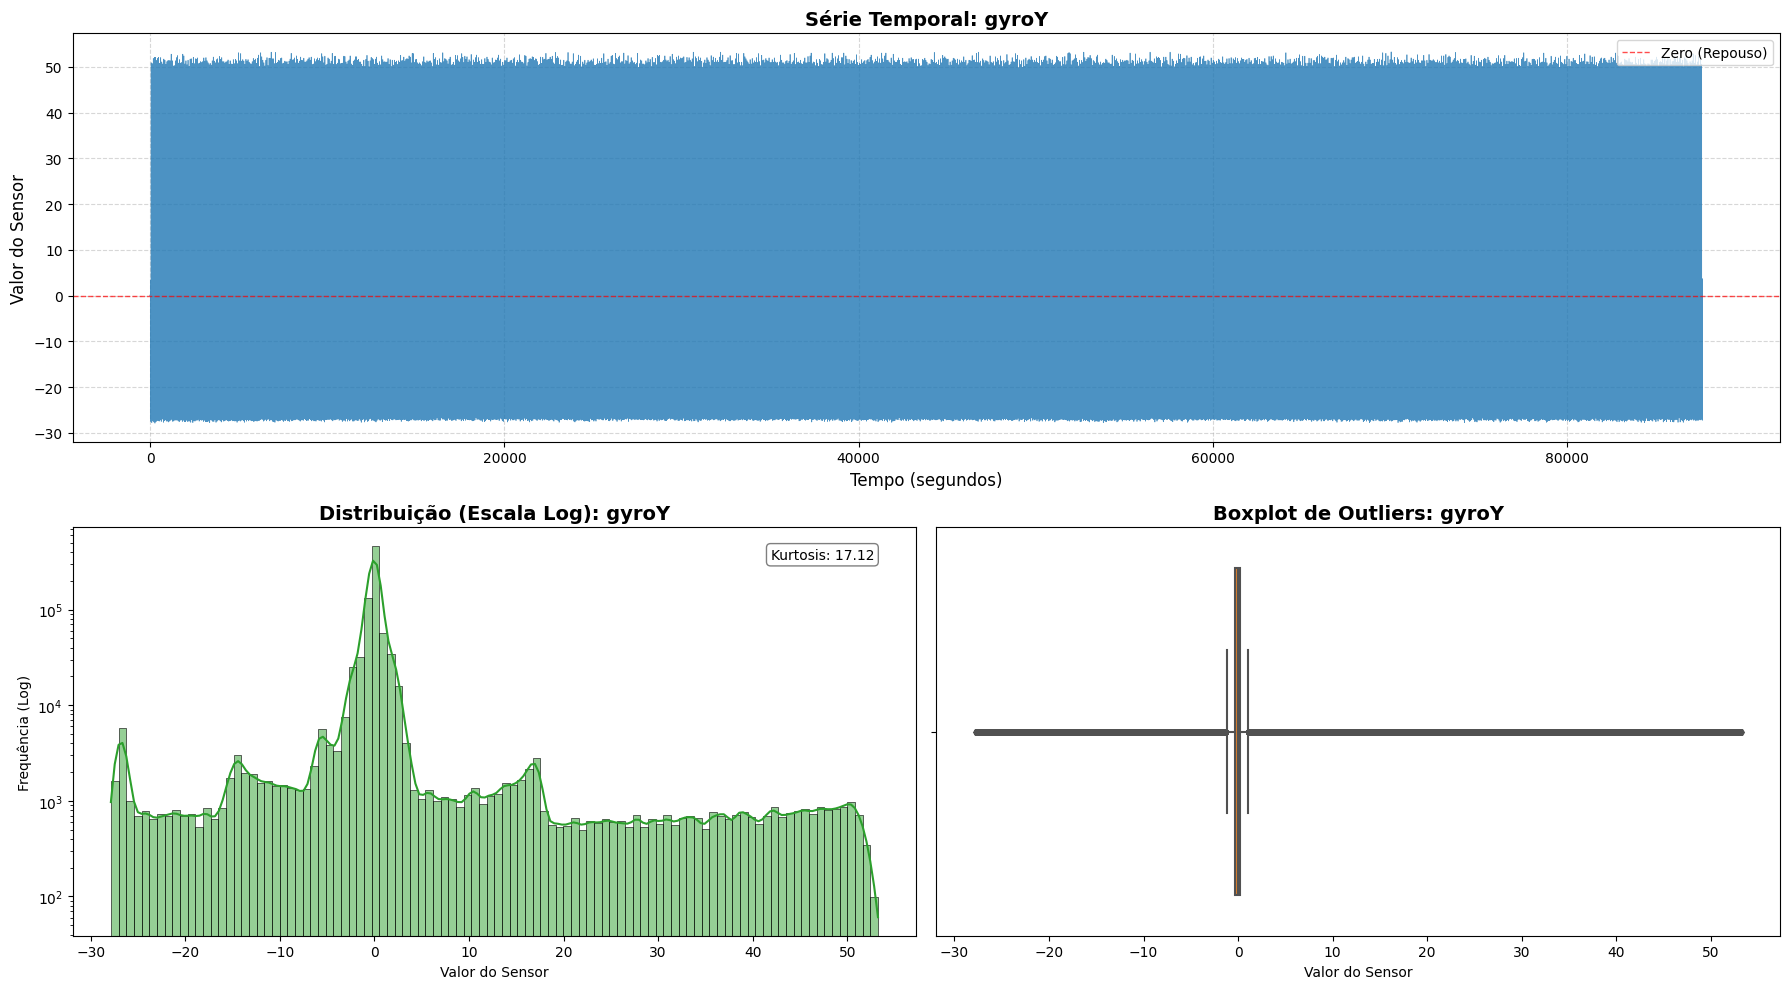

In [36]:
plot_sensor(df, col_sensor='gyroY')

- O boxplot mostra que não deve-se remover os outliers pela regra de desvio padrão (3-sigma), pois serão apagados o movimento do robô sobrando só o ruído dele parado

## Análise Exploratória Estrutural [Classe Anômala]
- Informações básicas do dataset
- Tipos de dados
- Informações detalhadas
- Estatísticas descritivas
- Análise de valores únicos

In [37]:
faultydf.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,label
0,IMU21,1.695906e+12,9.809044,0.016759,-0.011971,0.0,-0.1250,-0.0625,-35.040001,31.440001,8.692307,1
1,IMU21,1.695906e+12,9.821015,0.035913,0.016759,0.0,-0.0625,0.0000,-35.160000,31.760000,8.769231,1
2,IMU21,1.695906e+12,9.811439,0.031125,-0.019154,0.0,-0.0625,0.0000,-34.880001,31.559999,8.153846,1
3,IMU21,1.695906e+12,9.806650,0.019154,-0.014365,0.0,0.0000,0.0000,-35.040001,31.719999,8.538462,1
4,IMU21,1.695906e+12,9.792285,-0.002394,-0.019154,0.0,0.0625,0.0000,-34.880001,31.840000,8.769231,1


- Removendo a coluna `name` pois não agrega valor preditivo

In [38]:
faultydf = faultydf.drop(columns=['name'])

- Verificando duplicatas

In [39]:
print(f"Duplicatas de Tempo: {faultydf['time'].duplicated().any()}")

Duplicatas de Tempo: False


In [40]:
analise_estrutural_sensores(faultydf)

1. INFORMAÇÕES BÁSICAS E TIPOS DE DADOS
Dimensões do Dataset: 14967 linhas, 11 colunas

Tipos de Dados (Dtypes):
time     float64
accX     float64
accY     float64
accZ     float64
gyroX    float64
gyroY    float64
gyroZ    float64
magX     float64
magY     float64
magZ     float64
label      int64
dtype: object

Uso de Memória: 1.26 MB

2. ANÁLISE DE INTEGRIDADE TEMPORAL (CRÍTICO PARA IMU)
- Intervalo de Amostragem Médio (Sampling Rate): 100.167379 ms
- Frequência de coleta de dados: 9.98 Hz
- Jitter (Desvio Padrão do tempo): 22.796408 ms
- Gap Mínimo: 3.999512 ms | Gap Máximo: 244.000000 ms
- Qtd. de Gaps Temporais Significativos (> 2x média): 5

3. ANÁLISE DE VALORES ÚNICOS E CONSTANTES (SENSOR FREEZE)
          Tipo  Qtd_Unicos  Unicos (%)  Qtd_Zeros  Zeros (%)
magX   float64         847    5.659117          0   0.000000
gyroY  float64         926    6.186945       2394  15.995189
accZ   float64        1084    7.242600        377   2.518875
magZ   float64        1329    8.879535   

### Análise de Integridade Temporal
- Tamanho: desbalanceamento entre os dados normais e anômalos, enquanto que df possui	~875.000 linhas, faultydf tem ~15.000 linhas.
- Sampling Rate Médio: A frequência de coleta é a mesma no estado normal e de falha. `Sendo necessário resampling para 100ms e interpolate em ambos os conjuntos.` 
- Jitter (Desvio Padrão): Ambos têm um jitter significativo (~20ms).
- Gaps: O dataset normal tem uma quantidade muito maior de gaps de tempo 5 em relação a 429. `Ignorar Gaps como Feature de Anomalia`. Resample e interpolate é essencial para preencher esses gaps e garantir que a série temporal seja contínua para o Autoencoder ou modelos de janela deslizante sem introduzir o viés da falha de coleta.
- Gap Máximo: O maior gap está no dataset normal.

### Análise de valores únicos e constantes
- `accZ` é o ponto mais divergente e provavelmente a melhor feature física para detecção. Em relação aos dados normais, existe um aumento de 35x na ocorrência de zeros
- A proporção de valores únicos em `accY` é possível confirmar que a falha não é apenas parar, mas sim um comportamento dinâmico e irregular.
- `magX` e `magZ` têm poucos valores únicos em relação aos outros sensores, parecem sensores com baixa sensibilidade. Se precisar reduzir a complexidade do modelo, eles podem ser candidatos a serem removidos por Feature Selection.


- Visualizando `accZ`

C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


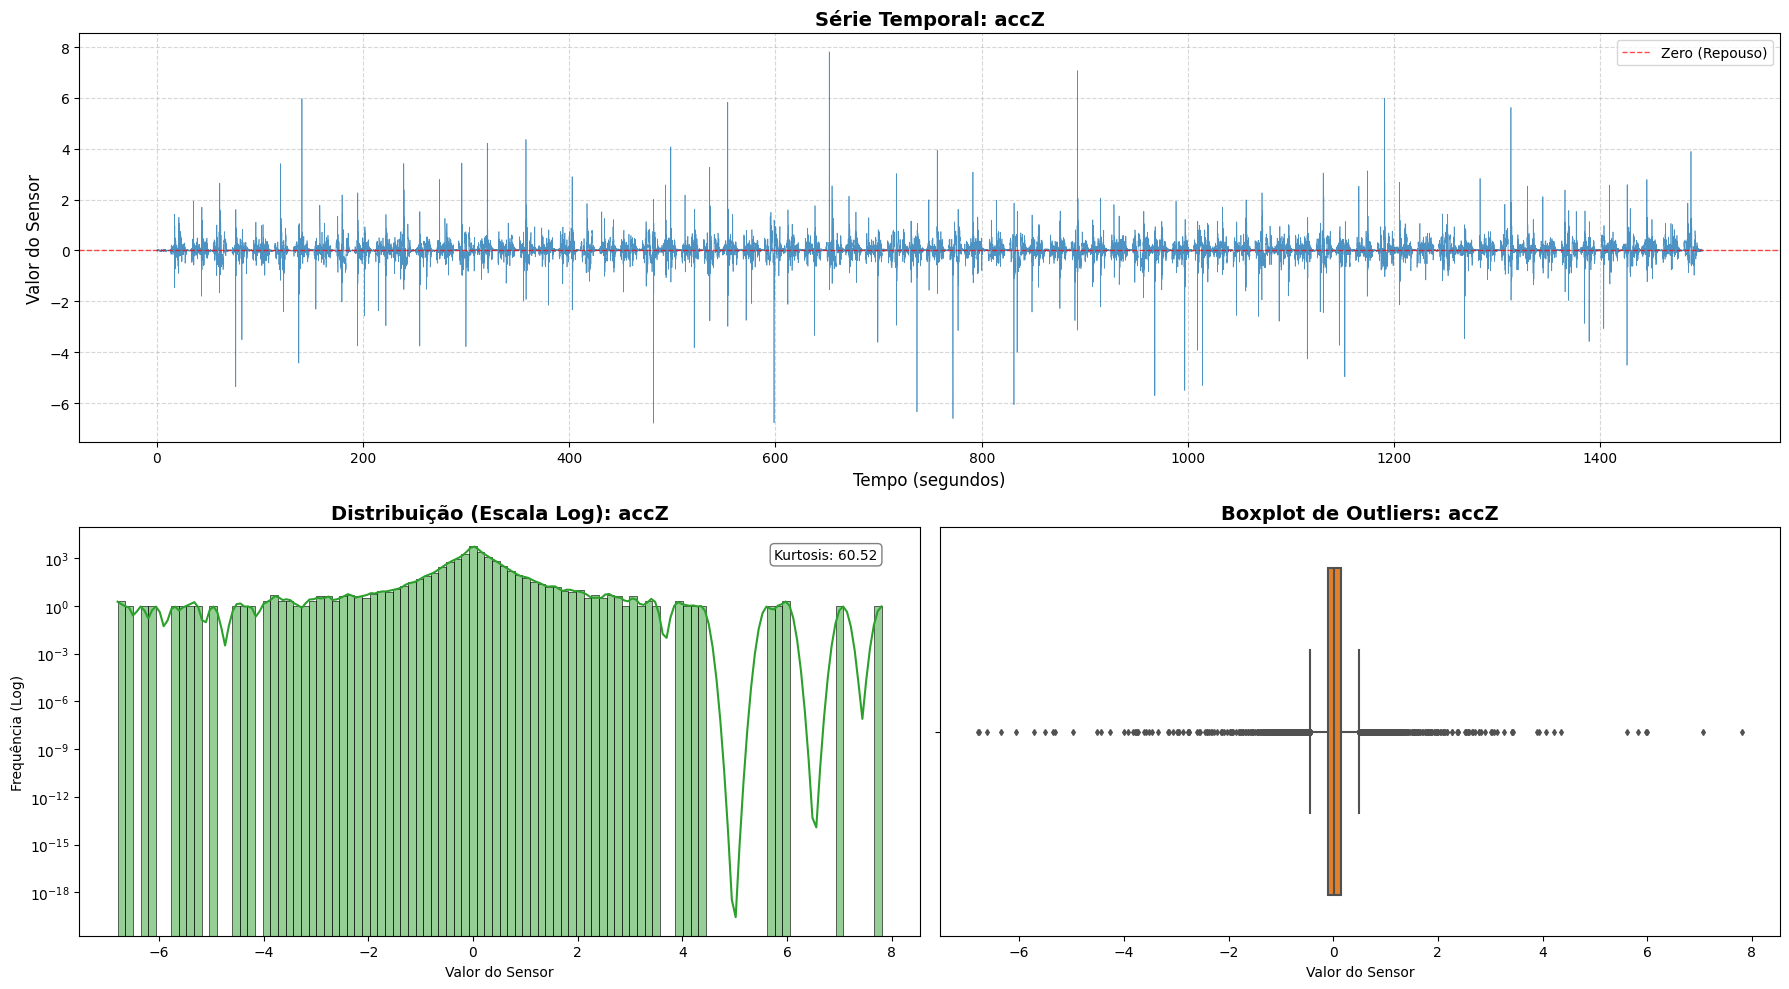

In [41]:
plot_sensor(faultydf, col_sensor='accZ')

- Comparando normal vs. falha

In [42]:
def comparar_normal_vs_falha(df_normal, df_falha, col_sensor):
    """
    Plota comparativo visual entre operação Normal e Falha (Ataque/Colisão).
    """
    # 1. Ajuste de Tempo (reseta para começar do zero em ambos para facilitar visualização)
    t_norm = (df_normal['time'] - df_normal['time'].iloc[0]) / 1e3
    t_fail = (df_falha['time'] - df_falha['time'].iloc[0]) / 1e3
    
    # Recorte: Pegar apenas os primeiros 10 segundos de cada para não poluir
    mask_norm = t_norm <= 10
    mask_fail = t_fail <= 10
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
    
    # --- PLOT 1: COMPARAÇÃO NO TEMPO ---
    # Normal
    axes[0].plot(t_norm[mask_norm], df_normal.loc[mask_norm, col_sensor], 
                 color='#1f77b4', label='Normal', alpha=0.7, linewidth=1)
    axes[0].set_title(f'Padrão Normal vs. Falha ({col_sensor})', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Valor do Sensor')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Falha (mesmo eixo para ver a diferença de magnitude)
    axes[0].plot(t_fail[mask_fail], df_falha.loc[mask_fail, col_sensor], 
                 color='#d62728', label='Falha (Hitting Platform)', alpha=0.7, linewidth=1)
    axes[0].legend()
    
    # --- PLOT 2: COMPARAÇÃO DE DENSIDADE (KDE) ---
    # Mostra se a "forma" dos dados mudou
    sns.kdeplot(df_normal[col_sensor], ax=axes[1], color='#1f77b4', fill=True, label='Normal')
    sns.kdeplot(df_falha[col_sensor], ax=axes[1], color='#d62728', fill=True, label='Falha')
    axes[1].set_title('Mudança na Distribuição de Probabilidade', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log') # Log para ver as caudas
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if 'name' in faultydf.columns: faultydf = faultydf.drop(columns=['name'])

C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

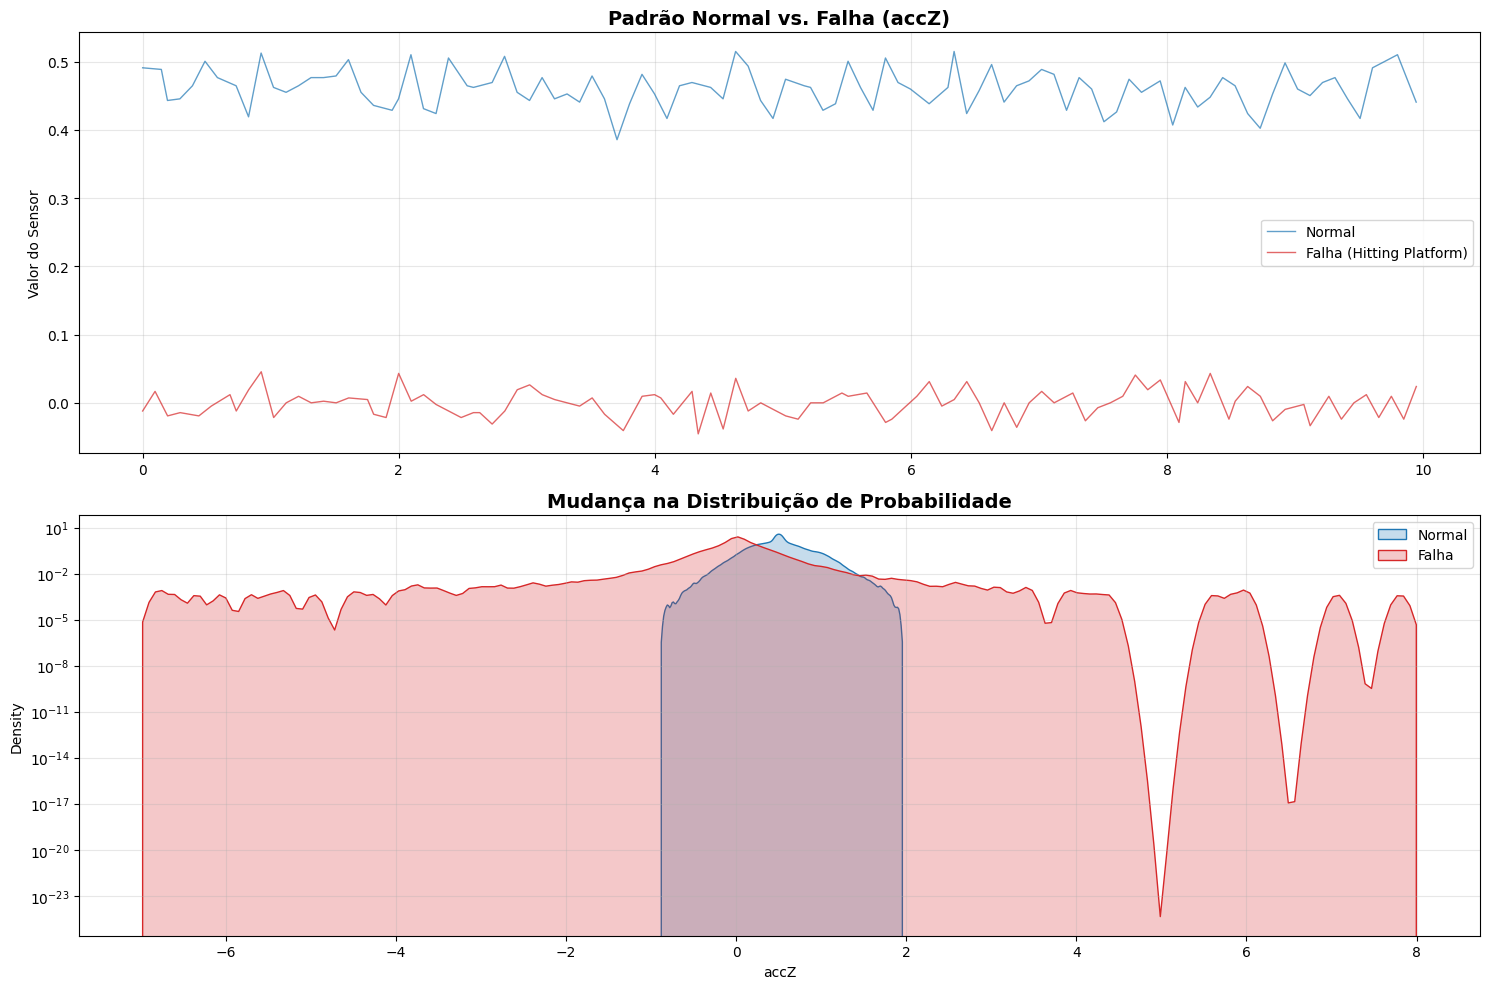

C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

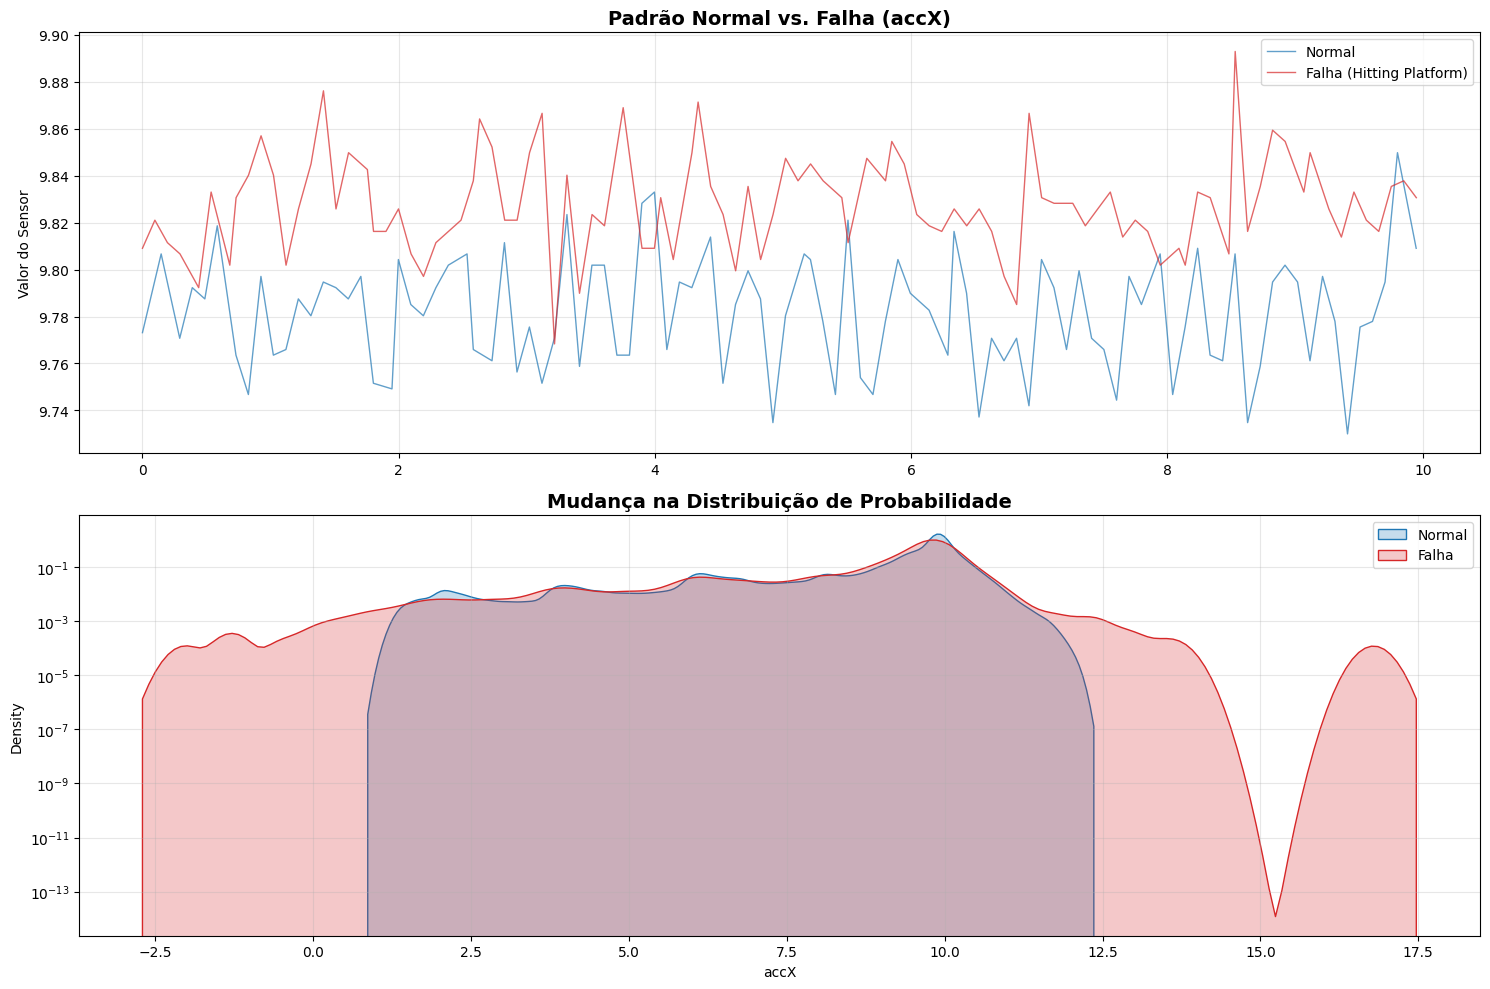

C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

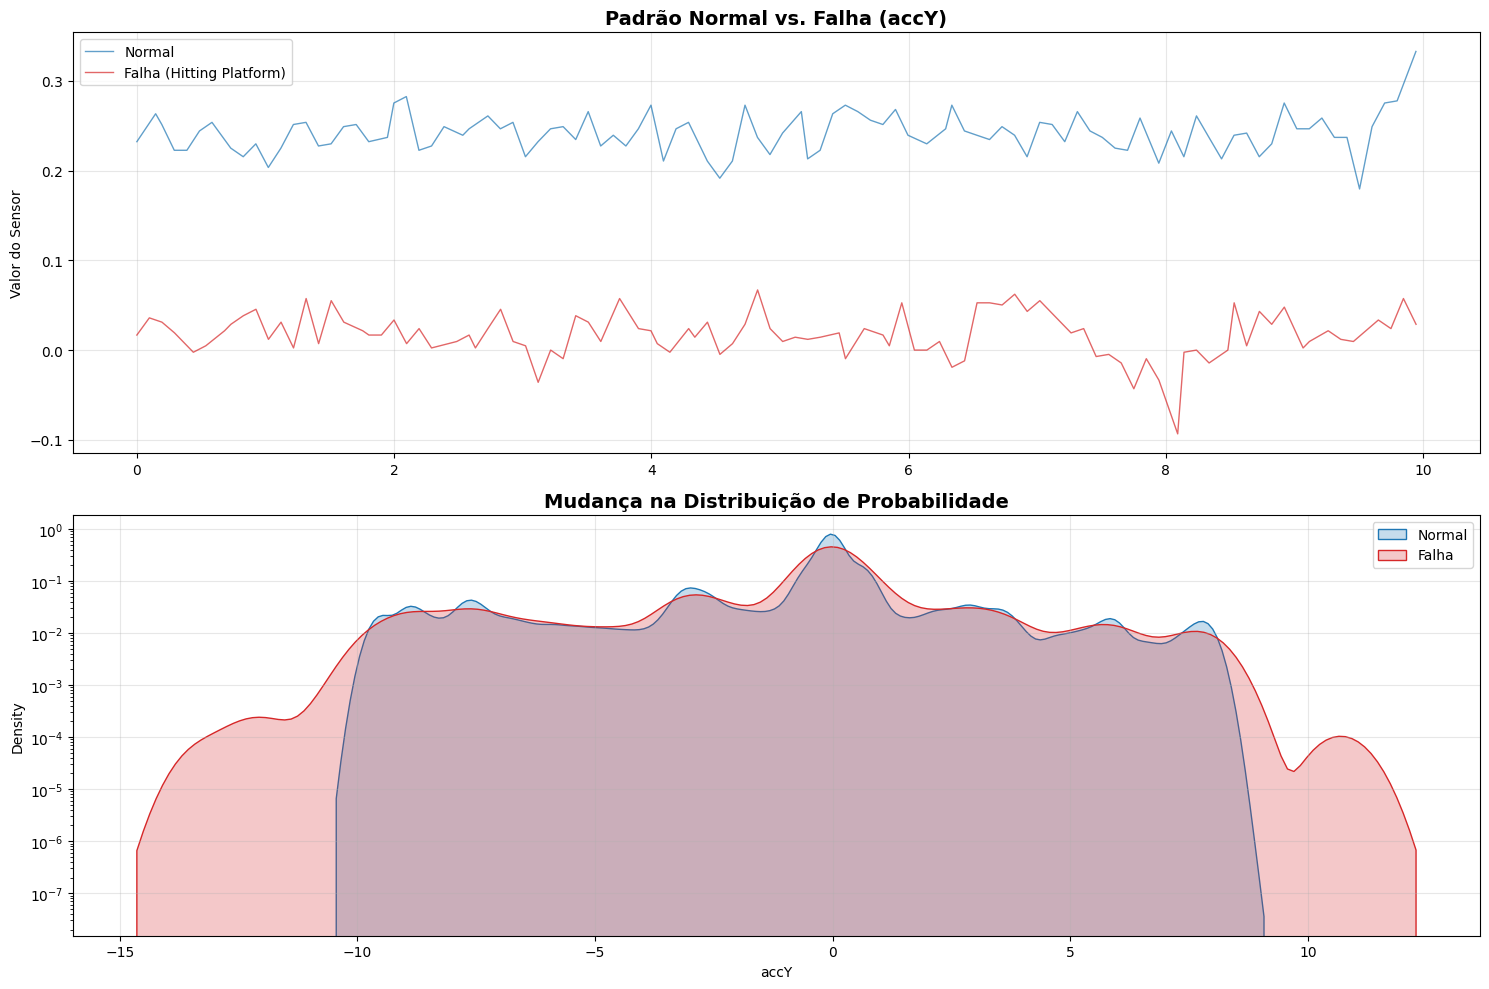

In [43]:
melhores_sensores = ["accZ", "accX", "accY"]

for sensor in melhores_sensores:
  comparar_normal_vs_falha(df, faultydf, col_sensor=sensor)

## Análise de Valores Faltantes e Outliers
- Identificação de valores faltantes e outliers
- Visualizações de apoio, caso necessário
- Análise dos mecanismos


In [44]:
print(f"Quantidade de valores faltantes em df: {df.isnull().sum().sum()}")
print(f"Quantidade de Valores faltantes em faultydf: {faultydf.isnull().sum().sum()}")

Quantidade de valores faltantes em df: 0
Quantidade de Valores faltantes em faultydf: 0


- Não serão removidos os outliers estatísticos pois são movimentos reais

- Resampling para 100ms

In [52]:
def resampling_and_interpolate(df, df_name):
    print(f"\nFazendo Resampling e Interpolate de {df_name}")
    # 1. Converter tempo para Datetime (necessário para resampling)
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')
    df = df.set_index('datetime')

    # 2. Resampling para 100ms (10Hz) - Ajuste conforme a média que vimos
    # .mean() pega todos os pontos que caíram naquele 0.1s e tira a média (reduz ruído)
    df_resampled = df.resample('100ms').mean()

    # 3. Verificar onde ficaram os buracos (NaNs gerados pelo resampling)
    print(f"Buracos gerados pelo alinhamento: {df_resampled['accX'].isnull().sum()}")

    # 4. Preencher buracos com Interpolação Linear
    # 'time' garante que a interpolação respeite a distância temporal
    df_final = df_resampled.interpolate(method='time')

    # 5. Drop nas colunas que não fazem sentido interpolar (ex: label)
    if 'label' in df_final.columns:
        df_final['label'] = df_resampled['label'].ffill().astype(int)

    print("Resampling concluído. Novo shape:", df_final.shape)
    
    return df_final

In [58]:
df_normal_resampled = resampling_and_interpolate(df, "df")
faultydf_resampled = resampling_and_interpolate(faultydf, "faultydf")


Fazendo Resampling e Interpolate de df
Buracos gerados pelo alinhamento: 44766
Resampling concluído. Novo shape: (876347, 11)

Fazendo Resampling e Interpolate de faultydf
Buracos gerados pelo alinhamento: 900
Resampling concluído. Novo shape: (14992, 11)


- Normalização com RobustScaler e StandardScaler

In [63]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

scaler = RobustScaler()
scaler.fit(df_normal_resampled)

df_normal_scaled = scaler.transform(df_normal_resampled)
df_faulty_scaled = scaler.transform(faultydf_resampled)

standardScaler = StandardScaler()
standardScaler.fit(df_normal_resampled)

df_normal_standard_scaled = standardScaler.transform(df_normal_resampled)
df_faulty_standard_scaled = standardScaler.transform(faultydf_resampled)

In [64]:
def diagnostico_preprocessamento(df_raw, df_resampled, df_scaled, 
                                 col_sensor='accZ', 
                                 window_sec=1.0, 
                                 scaler_name='RobustScaler'):
    """
    Gera um relatório visual comparando os estágios de pré-processamento.
    
    Args:
        df_raw: DataFrame original (Bruto).
        df_resampled: DataFrame após resampling e interpolação.
        df_scaled: DataFrame (ou array) após aplicação do Scaler.
        col_sensor: Nome da coluna do sensor para focar a análise.
        window_sec: Janela de tempo (em segundos) para o zoom do resampling.
        scaler_name: Nome do scaler usado (apenas para título).
    """
    
    # Configurar a figura
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # ====================================================================
    # PARTE 1: EFEITO DO RESAMPLING (ZOOM NO TEMPO)
    # ====================================================================
    ax1 = fig.add_subplot(gs[0, :])
    
    # Preparar dados de tempo para plotagem
    # Assumindo que df_raw['time'] é int (ns) e df_resampled index é datetime
    if 'time' in df_raw.columns:
        t_raw = (df_raw['time'] - df_raw['time'].iloc[0]) / 1e9
    else:
        # Tenta usar o índice se não tiver coluna time
        t_raw = np.arange(len(df_raw)) 
        
    t_res = (df_resampled.index - df_resampled.index[0]).total_seconds()
    
    # Recorte (Zoom) para ver os detalhes
    # Pegamos apenas os primeiros 'window_sec' segundos
    mask_raw = t_raw <= window_sec
    mask_res = t_res <= window_sec
    
    # Plotar pontos originais (Scatter para mostrar o Jitter/Irregularidade)
    ax1.scatter(t_raw[mask_raw], df_raw.loc[mask_raw, col_sensor], 
                color='black', alpha=0.6, s=30, label='Original (Raw Points)', zorder=3)
    
    # Plotar linha reamostrada (Linha + X para mostrar a grade fixa)
    ax1.plot(t_res[mask_res], df_resampled.loc[mask_res, col_sensor], 
             color='#1f77b4', linewidth=2, marker='x', markersize=8, 
             label='Resampled (10Hz Grid)', alpha=0.8, zorder=2)
    
    ax1.set_title(f'1. Efeito do Resampling: Regularização do Tempo ({col_sensor}) - Zoom de {window_sec}s', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tempo (segundos)')
    ax1.set_ylabel('Valor do Sensor (Físico)')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # ====================================================================
    # PARTE 2: EFEITO DO SCALER (DISTRIBUIÇÃO)
    # ====================================================================
    
    # Preparar o df_scaled se ele for um numpy array (saída comum do sklearn)
    if isinstance(df_scaled, np.ndarray):
        # Tenta encontrar o índice da coluna se for array
        try:
            col_idx = df_resampled.columns.get_loc(col_sensor)
            data_scaled = df_scaled[:, col_idx]
        except:
            data_scaled = df_scaled[:, 0] # Fallback
    else:
        data_scaled = df_scaled[col_sensor]

    # Plot A: Distribuição Original (Resampled)
    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(df_resampled[col_sensor], kde=True, ax=ax2, color='#1f77b4', bins=50)
    ax2.set_title(f'2a. Distribuição ANTES do Scaler\n(Unidades Físicas Reais)', fontsize=12, fontweight='bold')
    ax2.set_xlabel(f'{col_sensor} Original')
    
    # Plot B: Distribuição Escalada
    ax3 = fig.add_subplot(gs[1, 1])
    sns.histplot(data_scaled, kde=True, ax=ax3, color='#2ca02c', bins=50)
    ax3.set_title(f'2b. Distribuição DEPOIS do {scaler_name}\n(Unidades Relativas)', fontsize=12, fontweight='bold')
    ax3.set_xlabel(f'{col_sensor} Scaled')
    
    # Adicionar estatísticas de texto para comparação
    orig_mean, orig_std = df_resampled[col_sensor].mean(), df_resampled[col_sensor].std()
    scale_mean, scale_std = np.mean(data_scaled), np.std(data_scaled)
    
    txt = (f"Original:\nMédia={orig_mean:.2f}\nStd={orig_std:.2f}\nMin={df_resampled[col_sensor].min():.2f}\nMax={df_resampled[col_sensor].max():.2f}")
    ax2.text(0.95, 0.95, txt, transform=ax2.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    txt_sc = (f"Scaled:\nMédia={scale_mean:.2f}\nStd={scale_std:.2f}\nMin={np.min(data_scaled):.2f}\nMax={np.max(data_scaled):.2f}")
    ax3.text(0.95, 0.95, txt_sc, transform=ax3.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

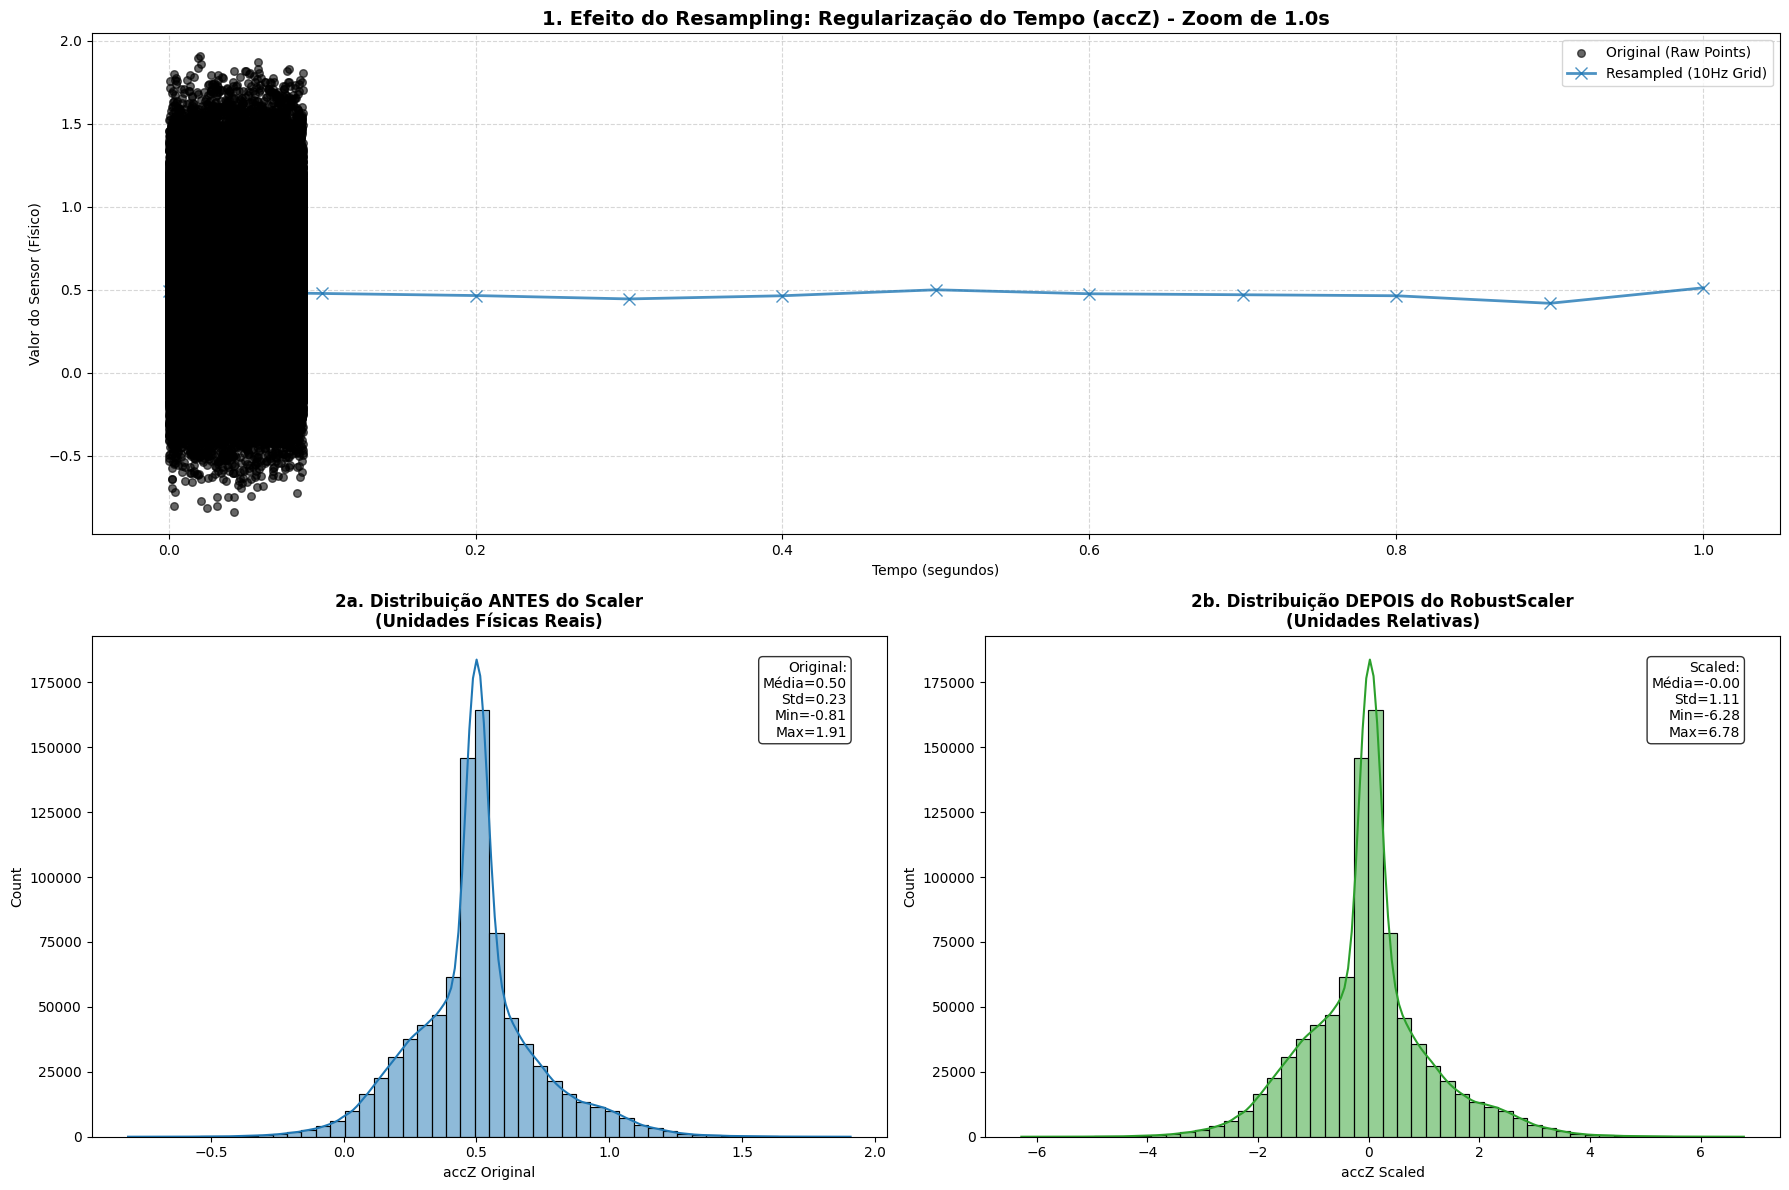

C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

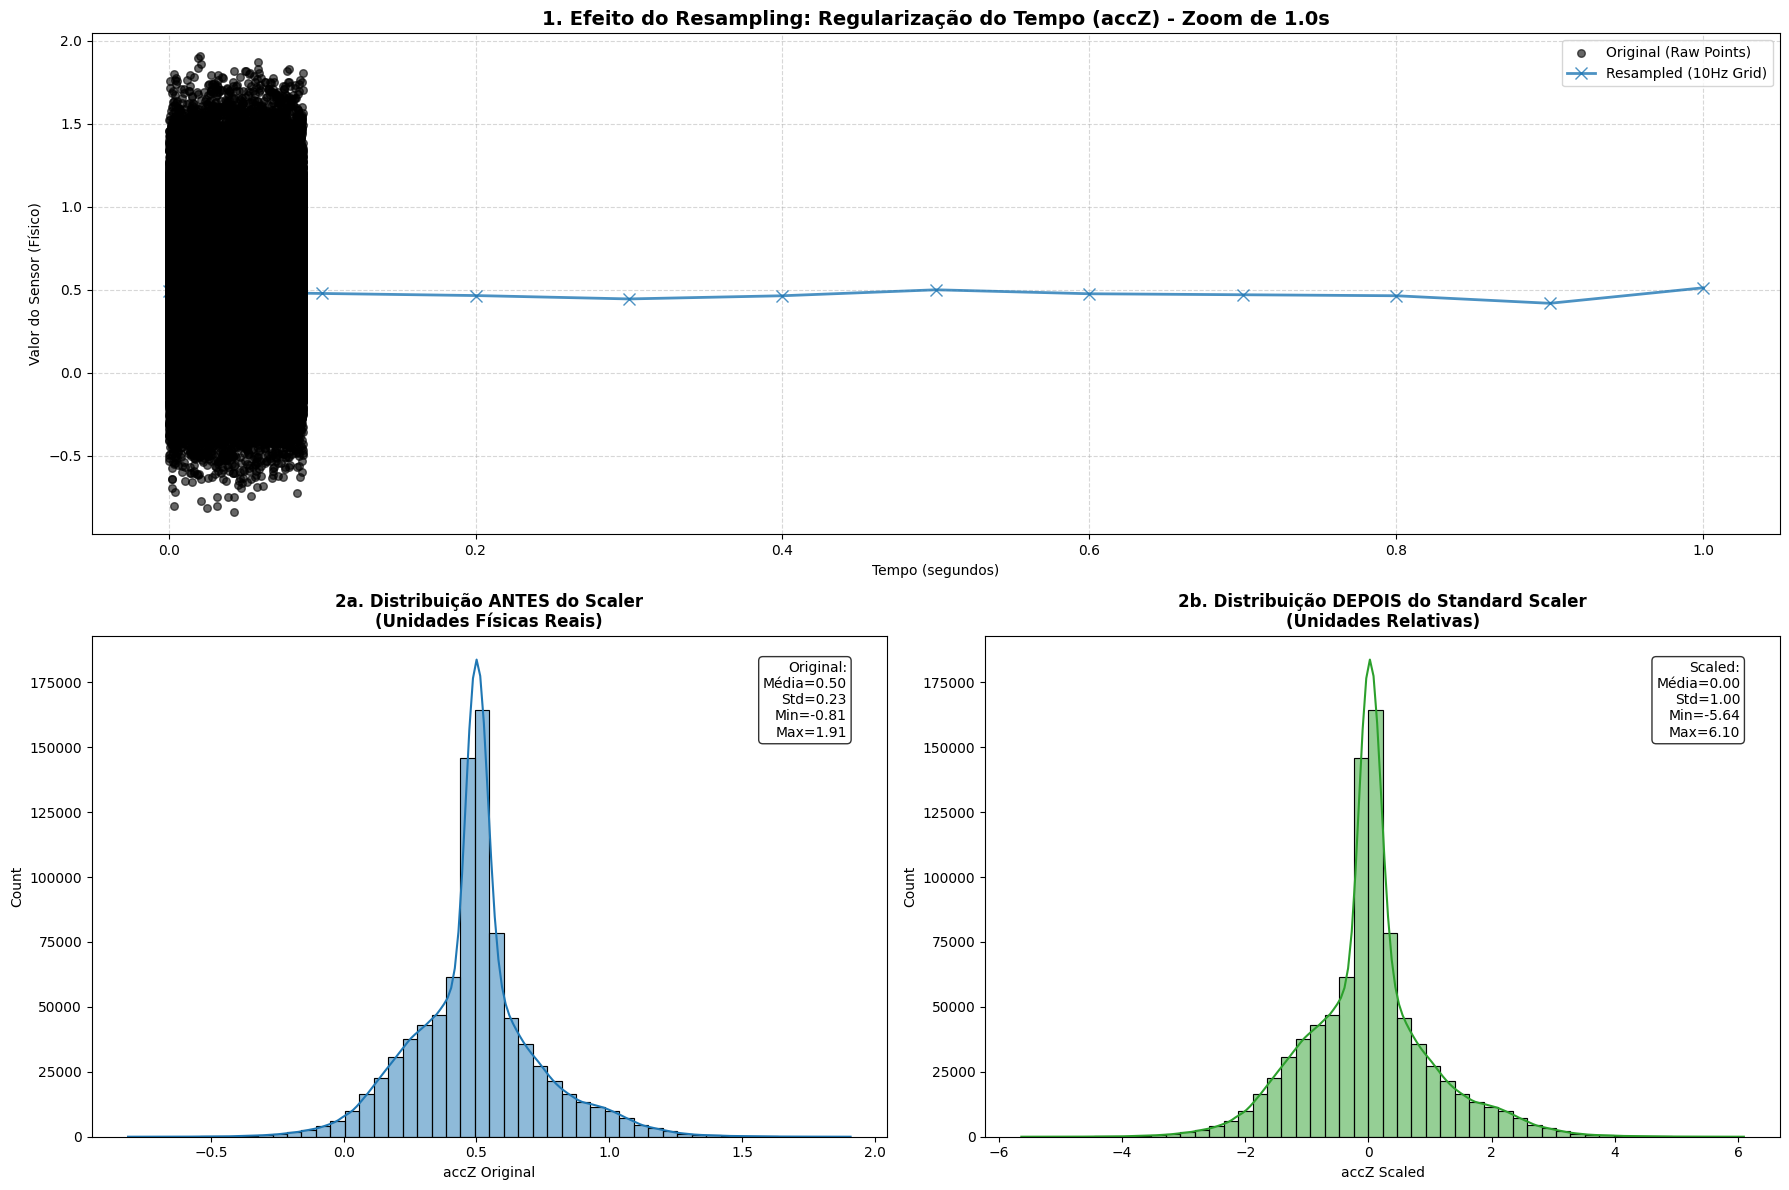

In [65]:
diagnostico_preprocessamento(df, df_normal_resampled, df_normal_scaled)
diagnostico_preprocessamento(df, df_normal_resampled, df_normal_standard_scaled, scaler_name="Standard Scaler")

## Análise Univariada
- Quantificar o quanto a distribuição de cada sensor muda quando o robô sai do estado "Normal" (0) para o estado "Falha" (1).

In [ ]:
def analise_univariada_alvo(df_normal, df_falha):
    """
    Realiza a análise univariada comparando atributos vs. alvo (Normal vs Falha).
    Gera estatísticas de separação e visualizações.
    """
    
    # 1. Preparar dados
    # Remover colunas não-sensor (time, label, name)
    cols_ignore = ['time', 'label', 'datetime', 'name']
    sensores = [c for c in df_normal.columns if c not in cols_ignore]
    
    stats_list = []
    
    # Configuração dos Plots
    # Vamos fazer um grid de 3 colunas
    n_cols = 3
    n_rows = (len(sensores) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
    axes = axes.flatten()
    
    print(f"Analisando {len(sensores)} sensores...\n")
    
    for i, sensor in enumerate(sensores):
        # Dados das duas classes
        data_norm = df_normal[sensor].dropna()
        data_fail = df_falha[sensor].dropna()
        
        # --- A. ESTATÍSTICA ---
        # 1. Diferença de Médias
        mean_diff = abs(data_fail.mean() - data_norm.mean())
        
        # 2. Razão de Variância (Quantas vezes a vibração aumentou?)
        # Adicionamos um epsilon pequeno para evitar divisão por zero
        var_ratio = data_fail.var() / (data_norm.var() + 1e-9)
        
        # 3. Teste Kolmogorov-Smirnov (Poder de Separação Geral)
        # statistic: 0 a 1 (quanto maior, melhor separa as classes)
        ks_stat, p_value = ks_2samp(data_norm, data_fail)
        
        stats_list.append({
            'Sensor': sensor,
            'KS_Statistic': ks_stat, # Principal métrica de separação
            'Variance_Ratio': var_ratio,
            'Mean_Diff': mean_diff,
            'P_Value': p_value
        })
        
        # --- B. VISUALIZAÇÃO (Violin Plot) ---
        # Criamos um mini-df temporário para o seaborn
        df_temp = pd.DataFrame({
            'Valor': np.concatenate([data_norm, data_fail]),
            'Estado': ['Normal'] * len(data_norm) + ['Falha'] * len(data_fail)
        })
        
        sns.violinplot(data=df_temp, x='Estado', y='Valor', ax=axes[i], 
                       palette={'Normal': '#1f77b4', 'Falha': '#d62728'}, split=False)
        
        axes[i].set_title(f'{sensor}\nKS Stat: {ks_stat:.3f}', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].grid(True, alpha=0.3)

    # Remover axes vazios se houver
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()
    
    # --- C. TABELA DE RANKING ---
    df_stats = pd.DataFrame(stats_list)
    # Ordenar pelo KS Statistic (Melhor separador primeiro)
    df_stats = df_stats.sort_values(by='KS_Statistic', ascending=False).reset_index(drop=True)
    
    print("="*60)
    print("RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)")
    print("="*60)
    print("KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível")
    print("Variance_Ratio: > 1.0 = Falha aumentou a variabilidade")
    print("-" * 60)
    print(df_stats[['Sensor', 'KS_Statistic', 'Variance_Ratio', 'Mean_Diff']])
    
    return df_stats

Analisando 9 sensores...



C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\bianc\AppData\Roaming\Python\Python312\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

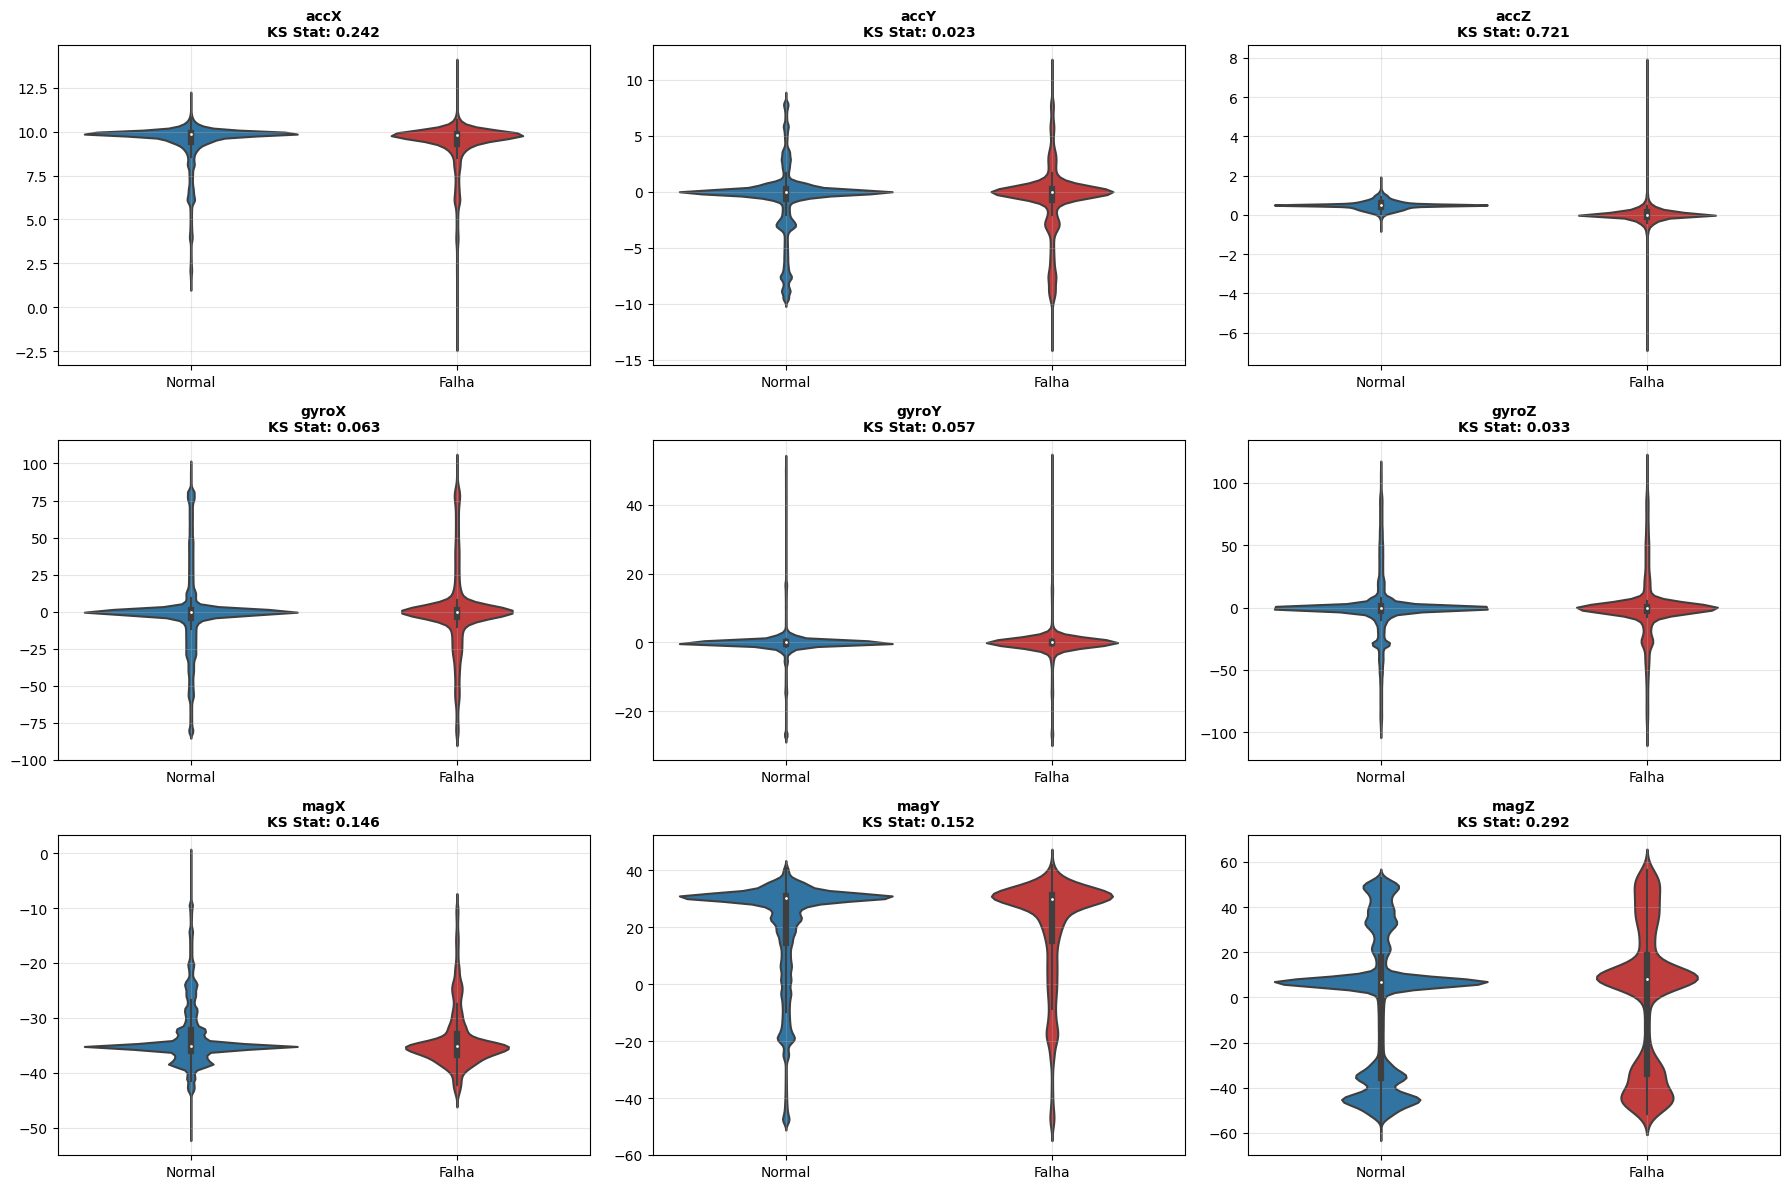

RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
Variance_Ratio: > 1.0 = Falha aumentou a variabilidade
------------------------------------------------------------
  Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0   accZ      0.720720        3.254453   0.476748
1   magZ      0.291977        1.022086   1.961425
2   accX      0.242462        1.031887   0.070068
3   magY      0.152211        1.001719   0.361481
4   magX      0.145993        0.951192   0.495011
5  gyroX      0.063415        0.998307   0.070330
6  gyroY      0.057022        0.974871   0.007856
7  gyroZ      0.032900        0.995919   0.023760
8   accY      0.023361        1.009183   0.010511


,Sensor,KS_Statistic,Variance_Ratio,Mean_Diff,P_Value
0,accZ,0.720720,3.254453,0.476748,0.000000e+00
1,magZ,0.291977,1.022086,1.961425,0.000000e+00
2,accX,0.242462,1.031887,0.070068,0.000000e+00
3,magY,0.152211,1.001719,0.361481,1.239849e-298
4,magX,0.145993,0.951192,0.495011,1.178172e-274
5,gyroX,0.063415,0.998307,0.070330,5.629322e-52
6,gyroY,0.057022,0.974871,0.007856,4.226894e-42
7,gyroZ,0.032900,0.995919,0.023760,2.692721e-14
8,accY,0.023361,1.009183,0.010511,2.024878e-07


In [68]:
analise_univariada_alvo(df_normal_resampled, faultydf_resampled) 

## PREPARAÇÃO DOS DADOS
- aplicando filtragem Savitzky–Golay para reduzir o ruído dos sensores

In [69]:
df.columns,faultydf.columns

cols = ["accX", "accY","accZ","gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]


In [70]:
df.loc[:, cols].describe( #remover time e label
        ).T.style.format("{:.4f}"
        ).background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
accX,874937.0000,9.2692,1.5163,1.1564,9.3948,9.8521,9.9575,12.0668
accY,874937.0000,-0.6796,3.0819,-9.8474,-0.6728,-0.0383,0.2466,8.4755
accZ,874937.0000,0.4951,0.2348,-0.8356,0.3783,0.4956,0.5866,1.9082
gyroX,874937.0000,0.3487,28.0195,-81.7500,-4.0000,0.0000,1.1875,98.0625
gyroY,874937.0000,0.6639,8.0825,-27.8750,-0.3750,0.0000,0.1875,53.2500
gyroZ,874937.0000,0.0182,26.3745,-100.9375,-3.0625,0.0000,1.3125,114.1250
magX,874937.0000,-33.3438,5.8454,-51.6400,-35.9600,-35.1600,-32.2800,0.0000
magY,874937.0000,19.5896,19.2806,-48.7600,14.6800,30.2000,30.8800,40.9600
magZ,874937.0000,-2.4805,31.4547,-59.3846,-35.6154,6.6154,17.6923,52.7692


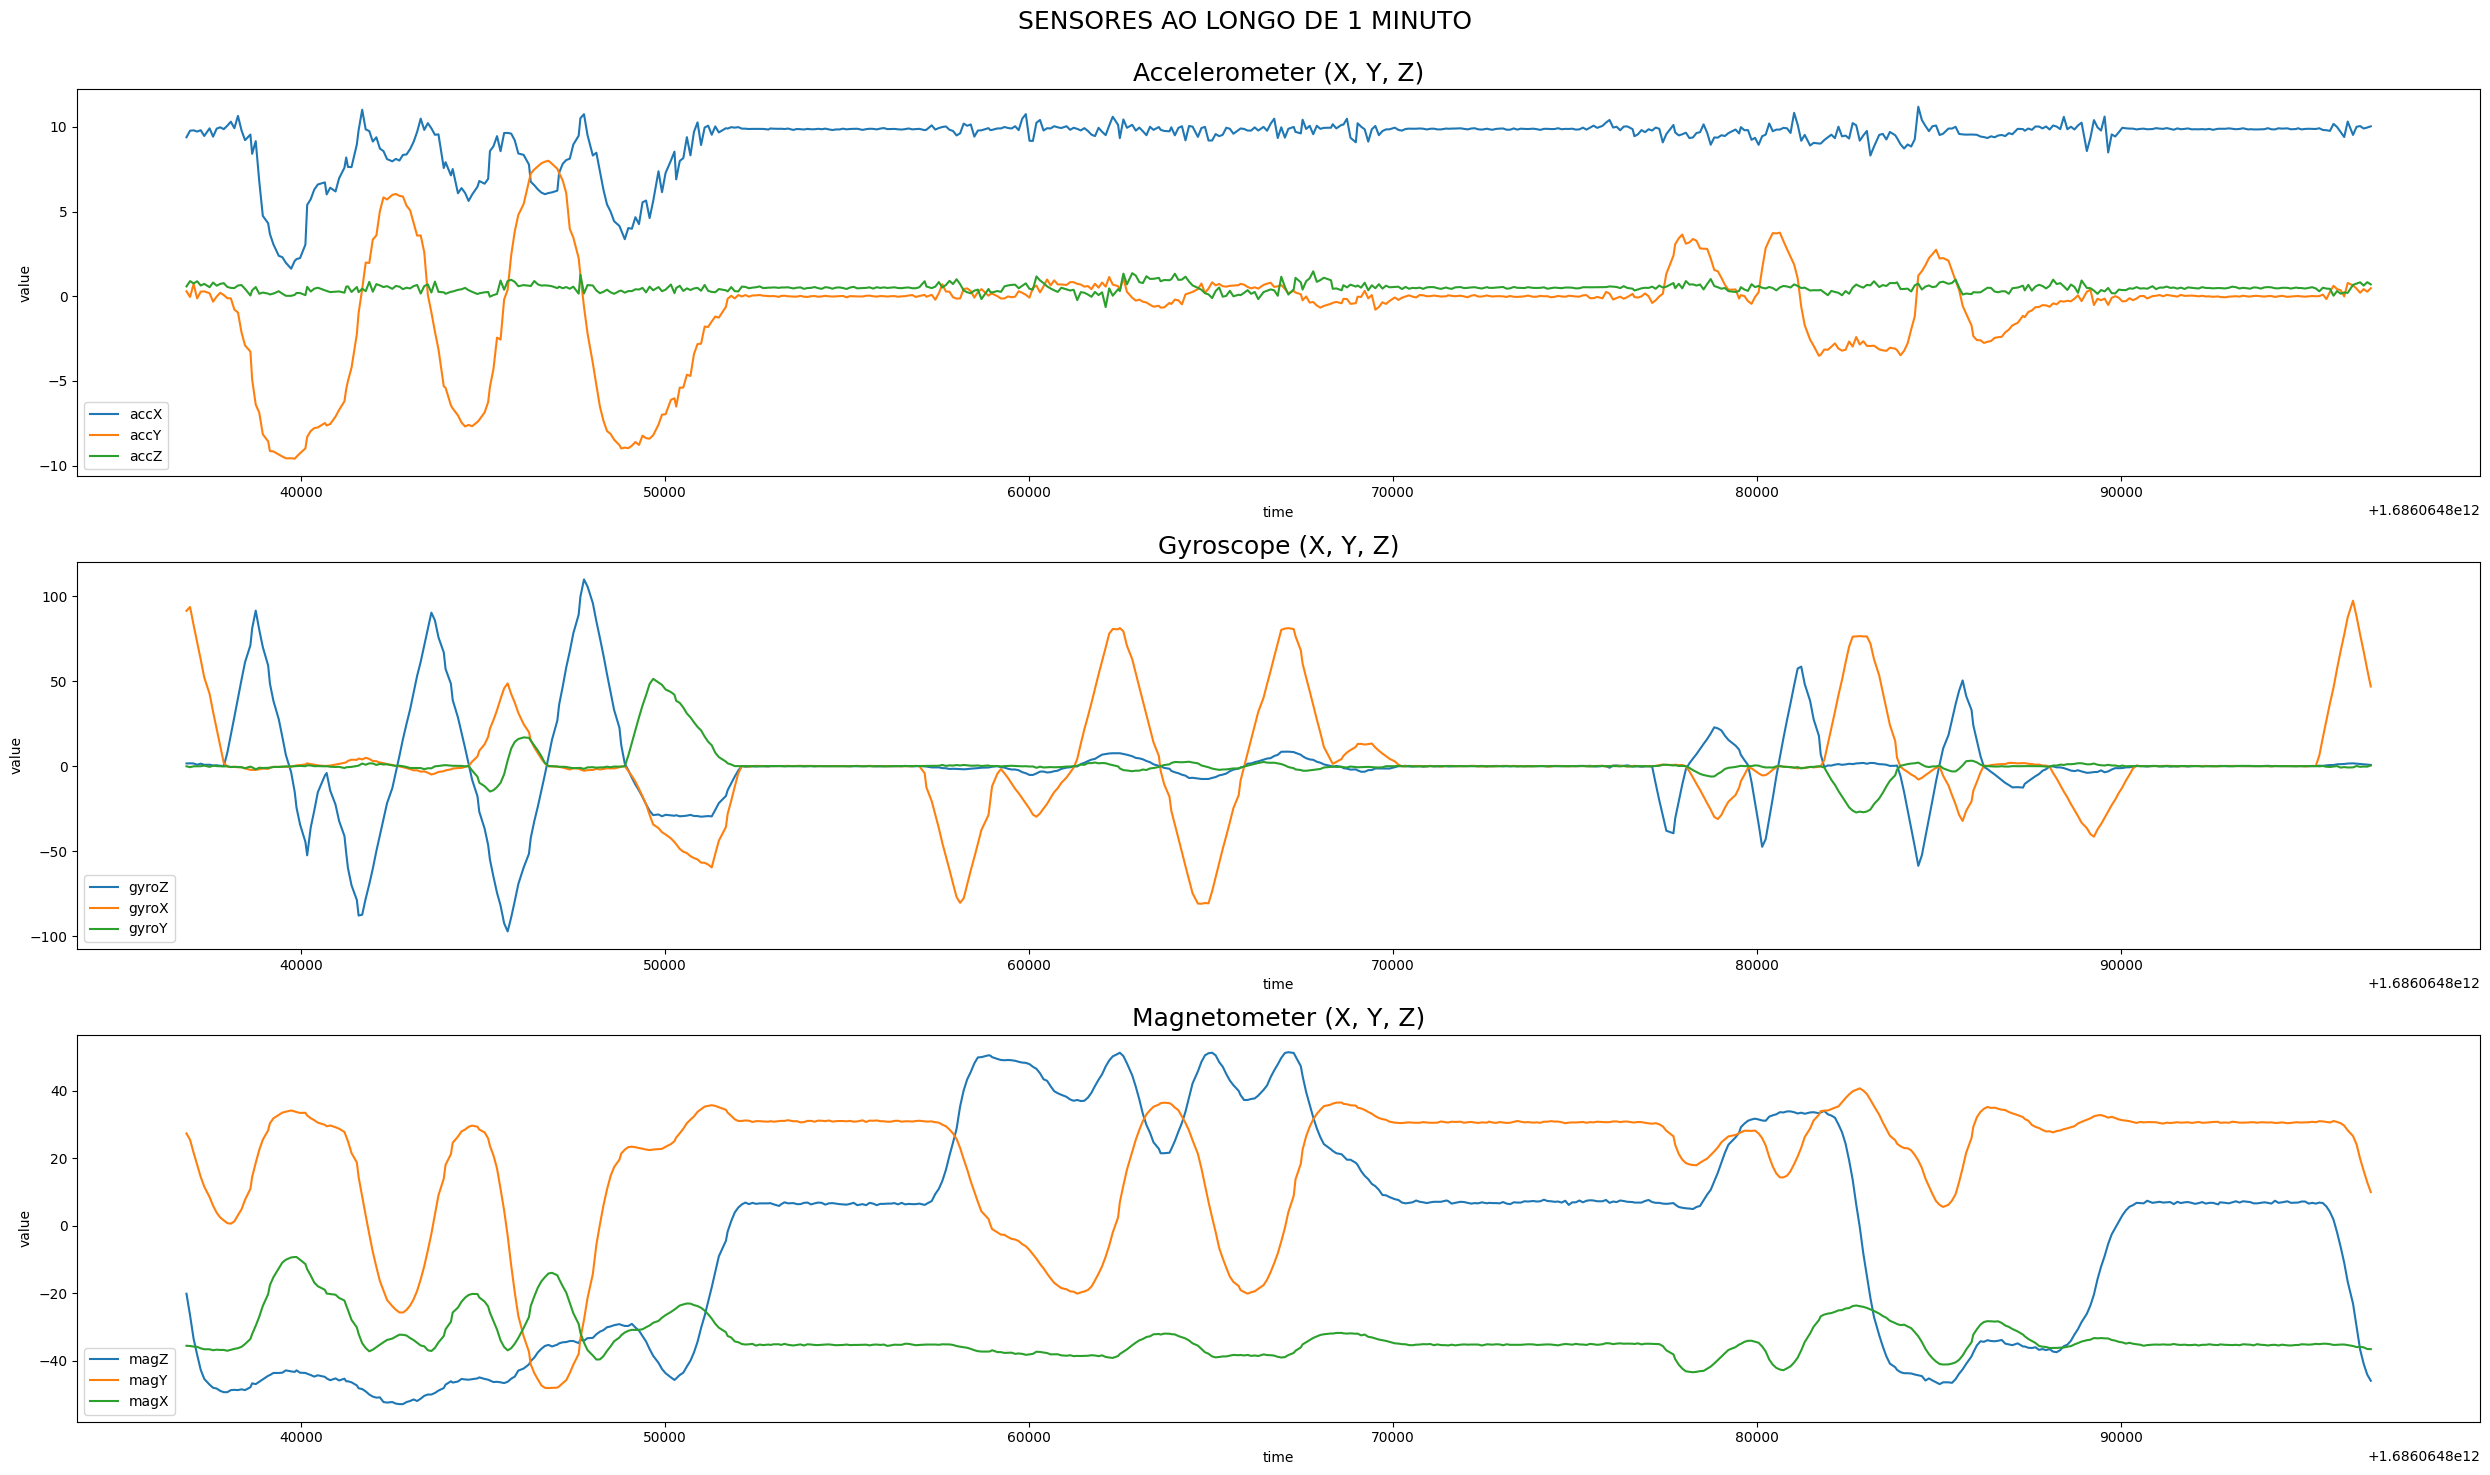

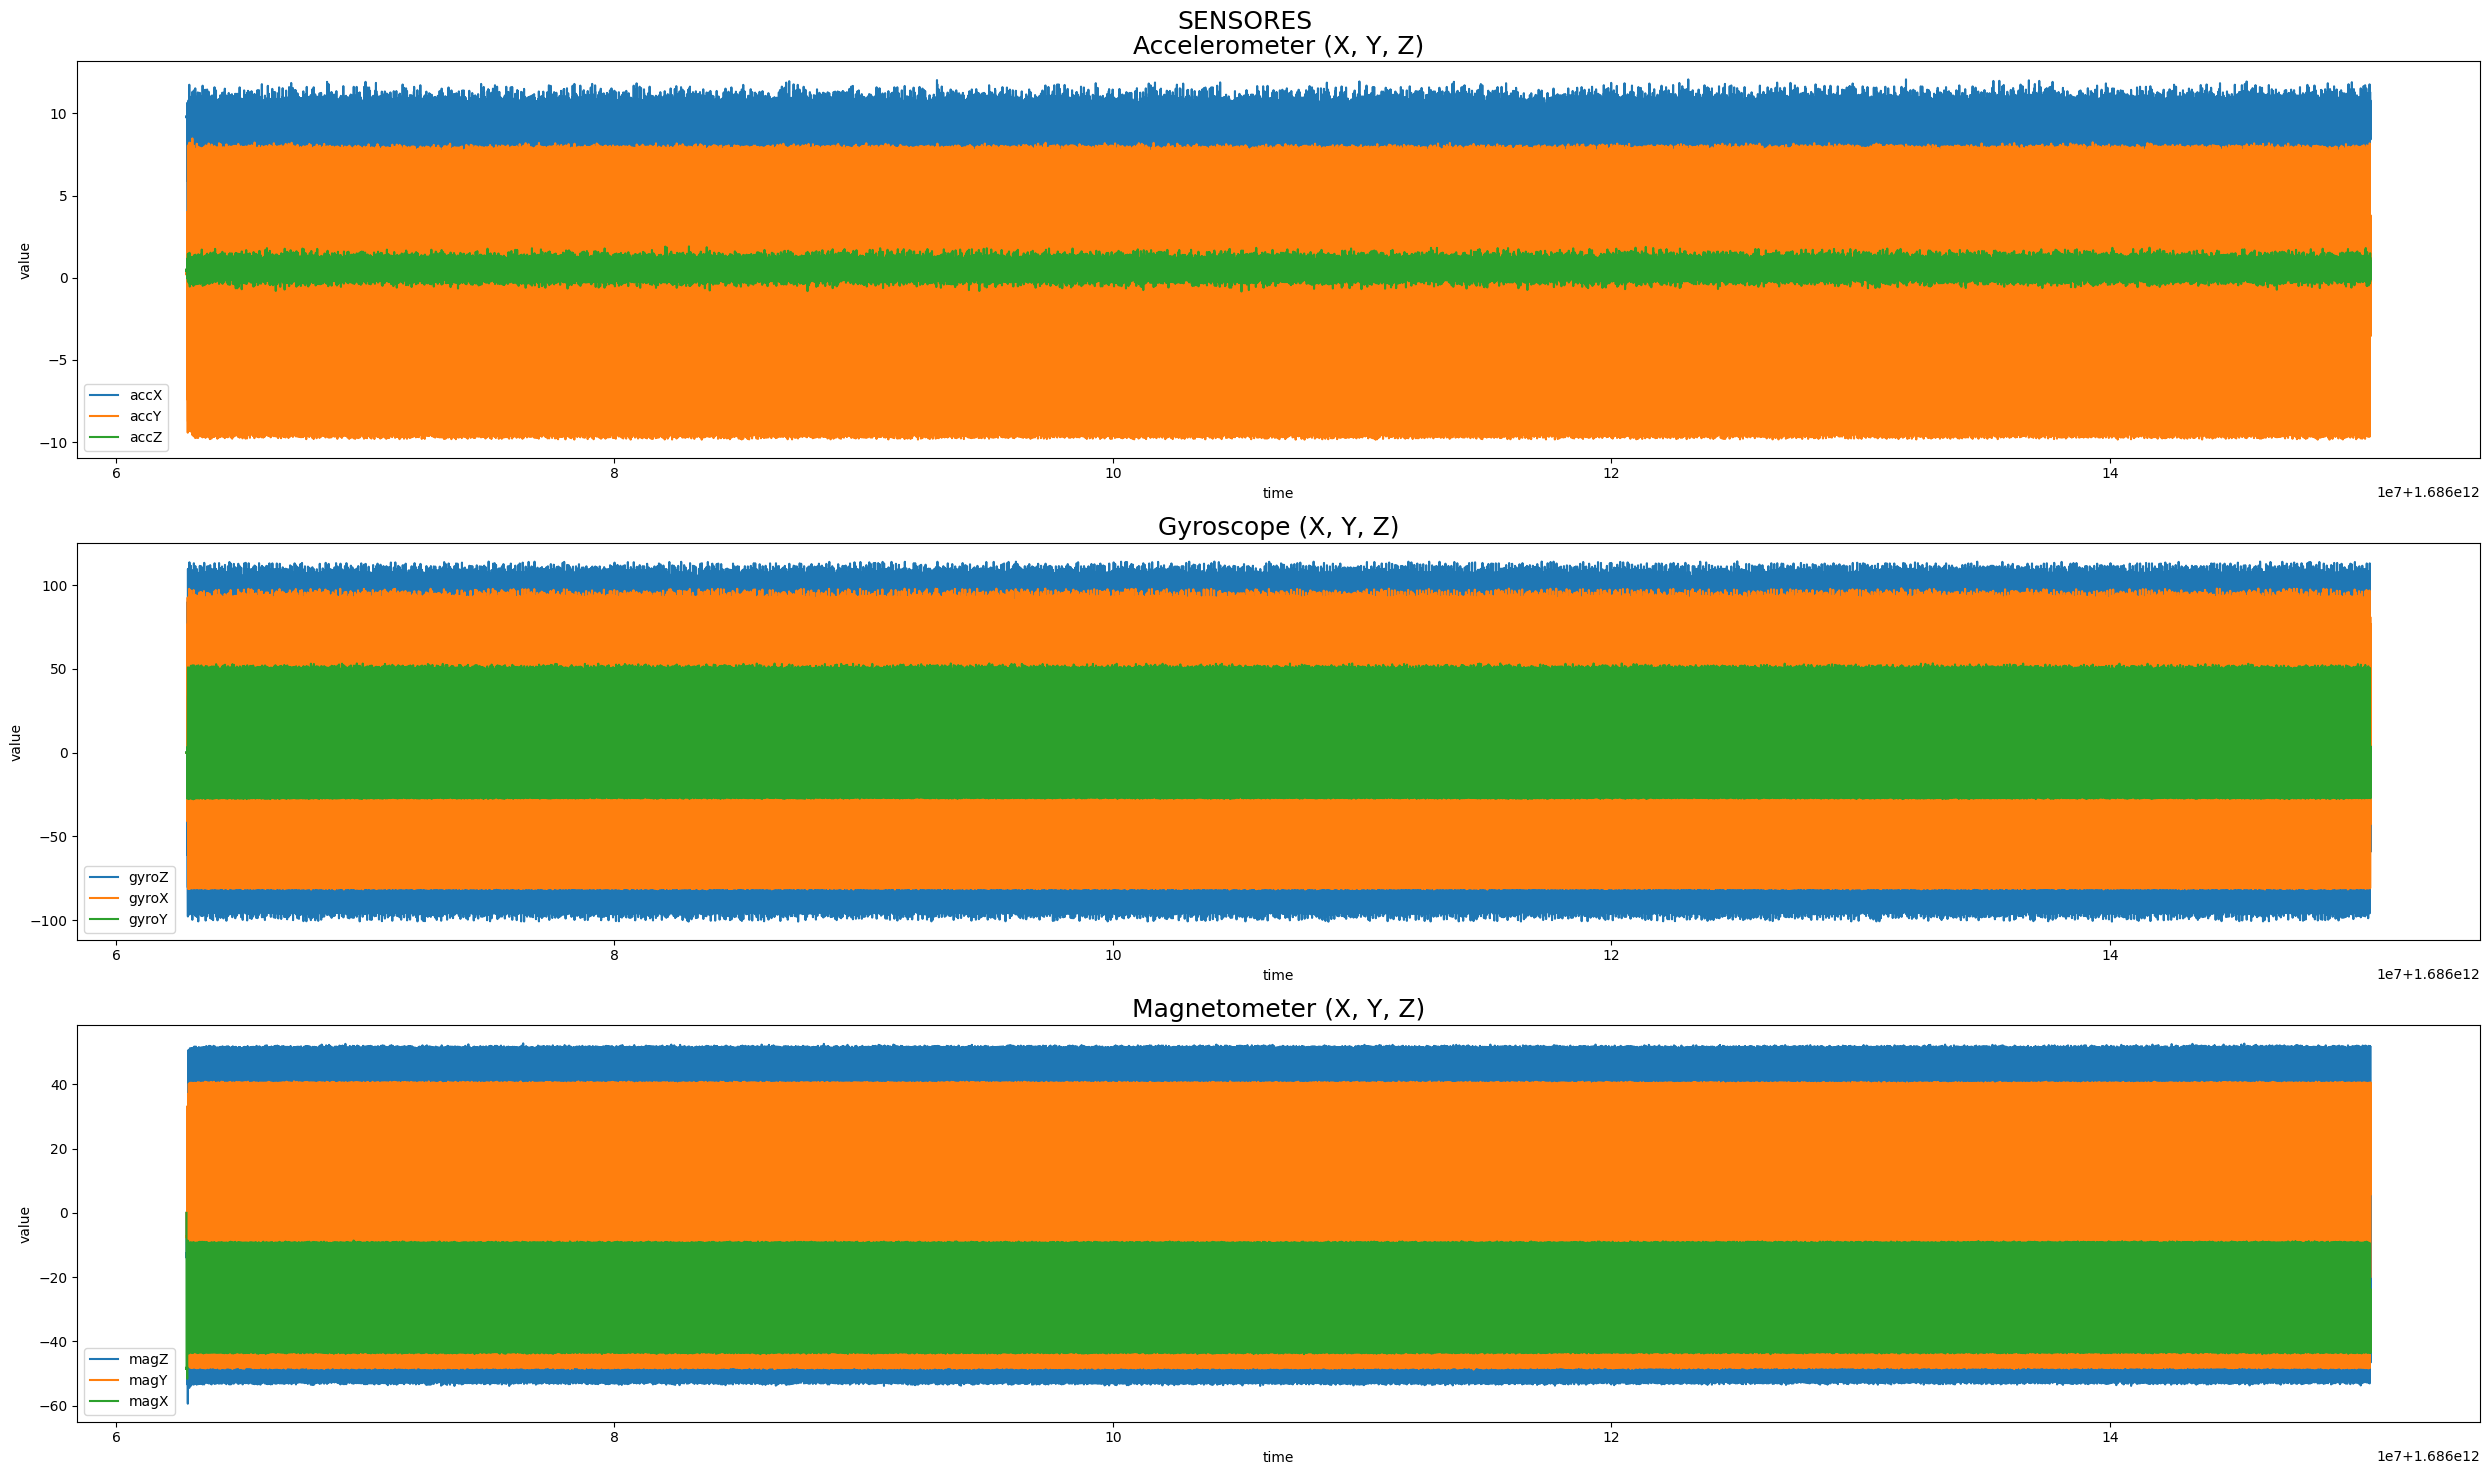

In [71]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
def plotSensors(dfPlot, step=1,suptitle="SENSORES AO LONGO DE 1 MINUTO\n",startTimeIdx=None,endTimeIdx=None):
    df = dfPlot.iloc[::step]
    fig = plt.figure(figsize=(25, 15))

    if not any((startTimeIdx, endTimeIdx)):
        startTimeIdx,endTimeIdx =  df['time'].iloc[0],df['time'].iloc[-1]
    else:
        startTimeIdx,endTimeIdx =  df['time'].iloc[startTimeIdx],df['time'].iloc[endTimeIdx]

    # Helper to plot three axes in the same subplot
    def plotSensorsSameGraph(ax, cols, title, x="time"):
        for col in cols:
            mask = (df['time'] >= startTimeIdx) & (df['time'] < endTimeIdx)
            ax.plot(df[mask][x], df[mask][col], label=col)

        ax.set_title(title, fontsize=18)
        ax.set_xlabel(x)
        ax.set_ylabel("value")
        ax.legend(loc='lower left')

    # === Subplots ===
    ax1 = fig.add_subplot(3, 1, 1)
    plotSensorsSameGraph(ax1,
                         cols=["accX", "accY","accZ"],
                         title="Accelerometer (X, Y, Z)")

    ax2 = fig.add_subplot(3, 1, 2)
    plotSensorsSameGraph(ax2,
                         cols=["gyroZ","gyroX", "gyroY", ],
                         title="Gyroscope (X, Y, Z)")

    ax3 = fig.add_subplot(3, 1, 3)
    plotSensorsSameGraph(ax3,
                         cols=["magZ", "magY", "magX"],
                         title="Magnetometer (X, Y, Z)")
    plt.suptitle(suptitle, fontsize='18')
    plt.tight_layout()
    plt.show()
plotSensors(df,startTimeIdx=20050, endTimeIdx=20050 + 60*10)
plotSensors(df,suptitle="SENSORES")

In [72]:
from scipy.signal import savgol_filter
# Savitzky-golay, um filtro bom pra series temporais (inspirado por https://www.nixtla.io/blog/polynomial_filtering)
for col in cols:
  df[col + "_smooth"] = savgol_filter(df[col], window_length=8, polyorder=2)


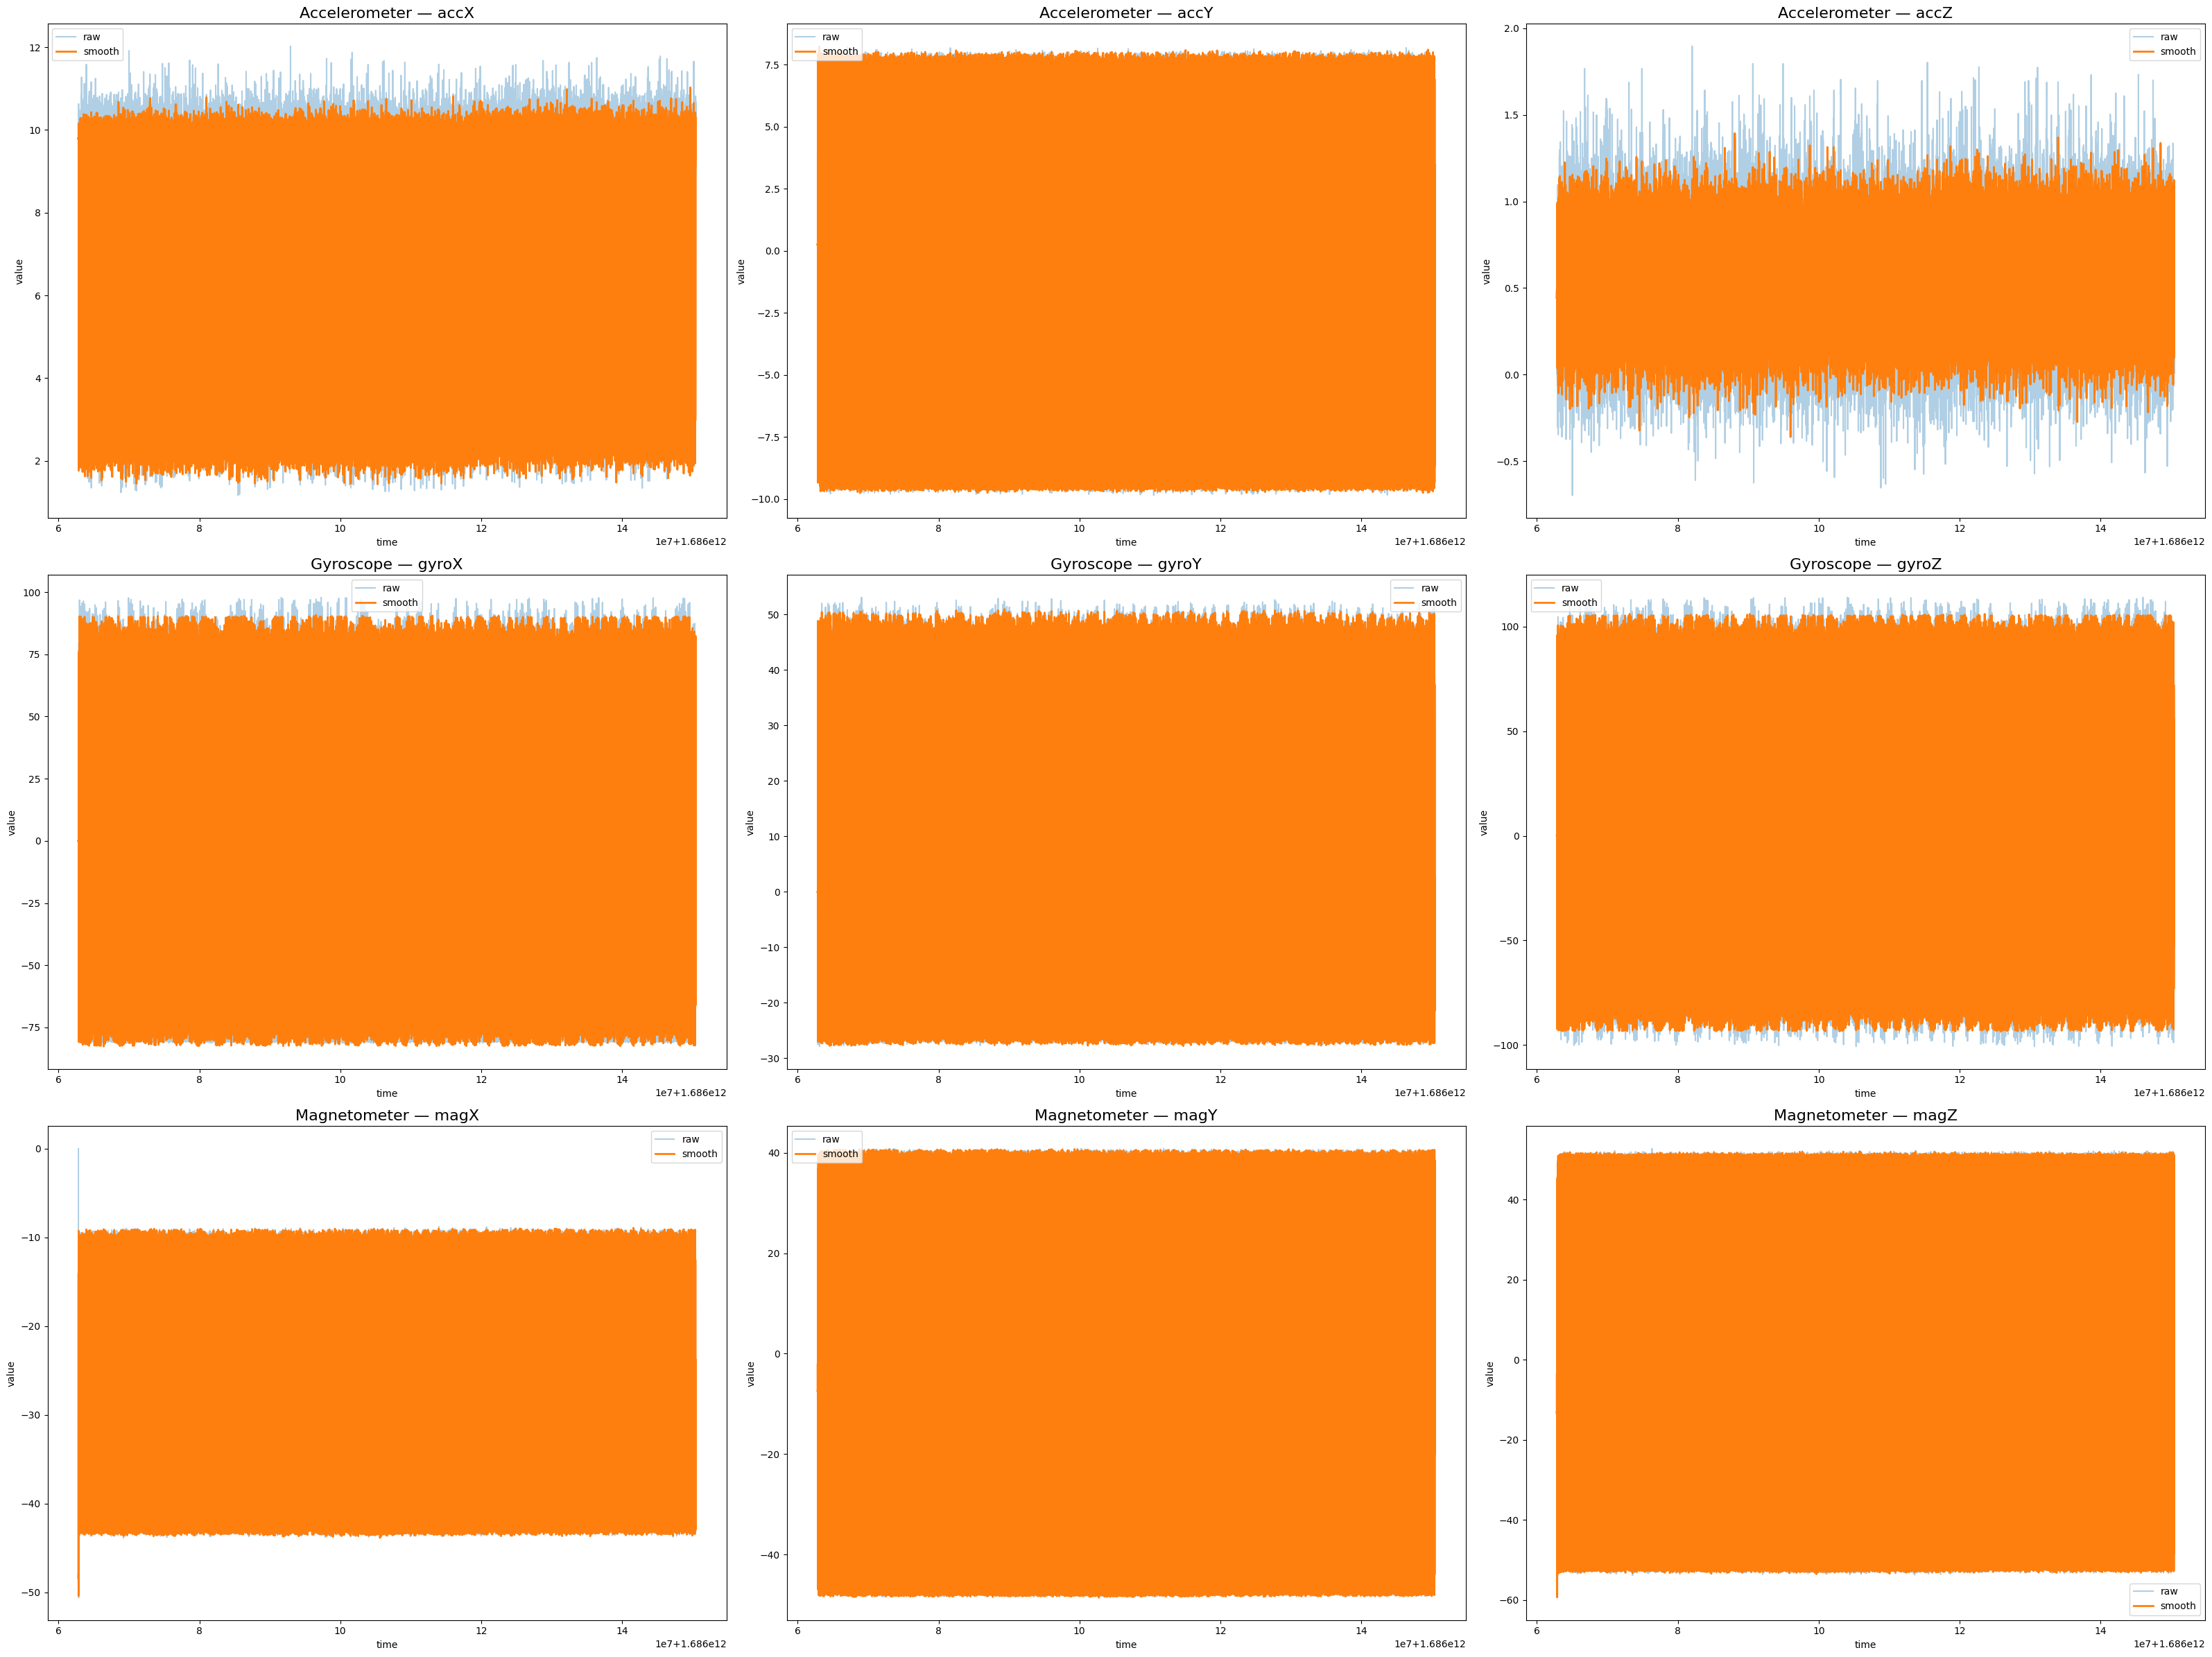

In [73]:
sensor_groups = [
    ("Accelerometer", ["accX", "accY", "accZ"]),
    ("Gyroscope", ["gyroX", "gyroY", "gyroZ"]),
    ("Magnetometer", ["magX", "magY", "magZ"])
]
def plot_raw_vs_smooth(df,step=10):
    fig, axes = plt.subplots(3, 3, figsize=(32, 24))
    df = df.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            smooth = df[axis + "_smooth"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], smooth, label="smooth", linewidth=2)

            ax.set_title(f"{title} — {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()

    plt.tight_layout()
    plt.show()
plot_raw_vs_smooth(df)

## Comparação antes e depois da filtragem

1. adicionar a imagem aqui porque é muito lento pra calcular)

1. Adicionar metricas de ruído
